# Pleiothropy all tasks

#### Data Preprocessing:
- merge all pedgree ID's 
- build a unique Pedigree
- merge all pheno files according the unique pedgree

#### Pleiothropy estimate:
- loop over pheno and estimate pleiothropy between each pair of pheno
- collect results in a dictionary of matrix:
    - pleio Matrix rhoG
    - P-value Matrix of rhoG different from 0
    - P-value Matrix of rhoG d
    ifferent from 1
    - pleio Matrix RhoE
    - P-value Matrix of RhoE different from 0
    - P-value Matrix of RhoE different from 1

#### Clutering Rho Matrices :
- cluster pleio Matrix rhoG
- plot clustered pleio Matrix rhoG
- plot clustered P-value Matrix of rhoG different from 0
- plot clustered P-value Matrix of rhoG different from 1
- cluster pleio Matrix RhoE
- plot clustered pleio Matrix RhoE
- plot clustered P-value Matrix of RhoE different from 0
- plot clustered P-value Matrix of RhoE different from 1

In [8]:
# Imports
import os
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import time
import seaborn as sns
import functools
import subprocess as subp
from nilearn import plotting as nlp
from scipy import cluster as scl
from scipy import io as sio
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec as gs
import itertools
import datetime
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import collections
import multiprocessing 
import datetime


In [9]:
def make_boxes(mat, cl_def, pad=1, edge=False):
    """
    mat:    the matrix you want to do stuff to
    cl_def: a list of tuples where the first position is the 
            index of the first element in the cluster. the 
            second position is the index of the last element 
            in the cluster
    pad:    an integer value for the number of zero spaces to add
            around clusters
    edge:   boolean argument. If True, clusters at the corners will
            be drawn full. If False, clusters will be only drawn on
            the inside edge (no white line around the matrix).
            
    returns:
    omat:   the input matrix with the spaces added
    cmat_m: the overlayed cluster boxes in a masked array
    lmat_m: a mask of the added empty spaces
    ind:    the new index positions for the data (for x_ticks...)
    """
    # Extract the values
    starts = [i[0] for i in cl_def if not i[0]==0]
    if edge:
        starts = [i[0] for i in cl_def]
        stops = [i[1]+1 for i in cl_def]
    else:
        starts = [i[0] for i in cl_def if not i[0]==0]
        stops = [i[1]+1 for i in cl_def if not i[1]+1>=mat.shape[0]]
    # Find the breakpoints
    bkp = list(np.unique(starts + stops))
    n_bkp = len(bkp)
    # Convert to new indices
    run = 0
    ind = list()
    for i in np.arange(mat.shape[0]):
        if i in bkp:
            run += pad
        ind.append(i+run)

    # Make indices
    x = [i[0] for i in itertools.product(ind, ind)]
    y = [i[1] for i in itertools.product(ind, ind)]

    # Make new matrix
    omat = np.zeros([i+n_bkp*pad for i in mat.shape])
    omat[x, y] = mat.flatten()

    # Make a matrix for the clusters
    cmat = np.zeros_like(omat)
    # Make a matrix for the empty lines
    lmat = np.zeros_like(omat, dtype=bool)
    lmat[x,y] = True
    lmat_m = np.ma.masked_where(lmat, lmat)
    # Convert the input based breakpoints
    starts_c = [ind[i[0]]-pad for i in cl_def]
    stops_c = [ind[i[1]]+1 for i in cl_def]
    for i in np.arange(len(starts_c)):
        start = starts_c[i]
        stop = stops_c[i]
        if pad==1:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
        else:
            start_ind = np.arange(start, start+pad)
            stop_ind = np.arange(stop, stop+pad)
            
        if not start<=0 or edge:
            # Draw the top left corner first
            cmat[start_ind, start:stop] = i+1
            cmat[start:stop, start_ind] = i+1
        else:
            # Draw the bottom right corner next
            cmat[stop_ind, :stop+pad] = i+1
            cmat[:stop+pad, stop_ind] = i+1
            continue
        if not stop>=omat.shape[0] or edge:
            # Draw the bottom right corner next
            cmat[stop_ind, start:stop+pad] = i+1
            cmat[start:stop+pad, stop_ind] = i+1
    cmat_m = np.ma.masked_where(cmat==0, cmat)
    return omat, cmat_m, lmat_m, ind

In [10]:
%matplotlib inline

In [103]:
# Set path 
#path_root = '/media/yassine/data_disk/Drive/HCP2/Solar_heritability/HCP_subtype/'
path_root = '/scratch/yassinebha/pleio/'

# Load files
pedig_df = pd.read_csv(os.path.join(path_root,'pleio_all_pheno_pedig.csv'))
pheno_df =  pd.read_csv(os.path.join(path_root,'hcp_all_pheno_clean_nonan_norm.csv'),
                        dtype={'Unnamed: 0':str}).rename(columns={'Unnamed: 0' : 'ID'})

# add HCP prefix to pheno file ID's
pheno_df['ID'] = ['HCP'+row.ID for idx,row in pheno_df.iterrows()]

In [12]:
# clean pheno file according to pedig file
pheno_clean_df = pd.merge(pedig_df[['ID']],pheno_df.drop(columns=['Handedness', 'Odor_Unadj']),how='left',on='ID').dropna()

pheno_clean_df.head()

,ID,SSAGA_Educ,BMI,BPSystolic,BPDiastolic,PSQI_Score,PicSeq_Unadj,CardSort_Unadj,Flanker_Unadj,PMAT24_A_CR,...,ASR_Rule_Pct,ASR_Intr_Pct,ASR_Intn_T,ASR_Extn_T,DSM_Depr_Pct,DSM_Anxi_Pct,DSM_Somp_Pct,DSM_Avoid_Pct,DSM_Adh_Pct,DSM_Antis_Pct
0,HCP100206,0.640665,-0.055687,-0.391613,-0.586484,0.251477,1.012772,0.414128,1.808004,0.733950,...,0.598684,1.129563,2.036715,1.146888,2.254271,1.501363,2.590293,2.105813,1.602376,0.819715
1,HCP100307,0.640665,-0.712932,-0.528777,-0.677497,-0.743000,-0.048759,0.862312,0.023611,0.118864,...,-0.560381,-0.681798,-0.885736,-0.323938,-0.682909,-0.624284,-0.684158,-0.707406,-0.659096,-0.431086
2,HCP100408,0.640665,0.142558,1.871597,1.506814,-0.080015,1.059755,-0.363632,0.884836,-1.931424,...,0.405506,-0.681798,-0.980008,-0.210797,-0.682909,-0.431043,-0.684158,-0.707406,-0.659096,-0.431086
3,HCP100610,0.640665,1.778527,1.117194,-0.222433,-0.080015,-0.164015,1.454382,1.419354,1.349037,...,-0.753559,-0.138390,0.434081,-0.323938,-0.682909,-0.624284,-0.684158,2.602263,-0.833056,-0.639553
4,HCP101006,-1.545133,0.592628,0.362791,0.869723,-0.743000,-1.952321,-0.942091,-1.046425,-1.111309,...,-0.367204,-0.681798,-1.168554,-0.210797,-0.682909,-0.624284,-0.684158,-0.707406,-0.833056,-0.639553


In [13]:
# Save pheno clean 
pheno_clean_df.to_csv(os.path.join(path_root,'hcp_all_pheno_clean_nonan_norm_pleio.csv'),index=False)

### Pleiothropy estimate:

In [7]:
#initiate empty dictionary
Pleio_RhoG = collections.namedtuple('Pleio_RhoG', ['out_dir',
                                                   'pedig_f',
                                                   'pheno_f',
                                                   'var_1',
                                                   'var_2'
                                                  ])
pleio_RhoGs = []

# pleio root folder
path_pleio = os.path.join(path_root,'pleio_{}'.format(str(datetime.date.today())))
if not os.path.exists(path_pleio):
    os.makedirs(path_pleio)

# create ouput folders and populate RhoG dictionnary
for ix_pheno_1, pheno_1 in enumerate(pheno_clean_df.columns.drop('ID')):
    for ix_pheno_2, pheno_2 in enumerate(pheno_clean_df.columns.drop('ID')):
        if pheno_1  == pheno_2:
            continue
        print(pheno_1,pheno_2)
        
        # output result folder 
        path_pleio_contrast = os.path.join(path_pleio,'{}_{}'.format(pheno_1,pheno_2))
        if not os.path.exists(path_pleio_contrast):
            os.makedirs(path_pleio_contrast)
            
        # copy needed files to output folder
        if not os.path.isfile(os.path.join(path_pleio_contrast,'se_univ_polygen.tcl')):
            subp.run(['cp',os.path.join(path_root,'se_univ_polygen.tcl'),path_pleio_contrast])
        if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_pheno_run.sh')):
            subp.run(['cp',os.path.join(path_root,'pleio_pheno_run.sh'),path_pleio_contrast])
            
        # pedegree
        if not os.path.isfile(os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')):
            subp.run(['cp',os.path.join(path_root,'pleio_all_pheno_pedig.csv'),path_pleio_contrast]) 
            
        pedig_f = os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')
        
        # pheno cov stack
        df_pheno = pheno_clean_df[['ID',pheno_1,pheno_2]]
        #cov_1 = '{}_FD_scrubbed_mean'.format(pheno_1.split('_')[0])
        #cov_2 = '{}_FD_scrubbed_mean'.format(pheno_2.split('_')[0])
        #df_cov = cov_stack_FD_df[['ID',cov_1,cov_2]]
        #pheno_cov_stack = [df_pheno,df_cov,cov_stack_stand_df]
        
        # merge pheno cov
        #pheno_cov_df = functools.reduce(lambda left,right: pd.merge(left,right,on='ID',how='inner'), 
        #                                pheno_cov_stack)
        # save pheno cov to file
        pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
        if not os.path.isfile(pheno_f):
            df_pheno.to_csv(pheno_f,index=False)   
        
        # collect all pleio contrasts in dictionary
        pleio_RhoGs.append(Pleio_RhoG(out_dir = path_pleio_contrast,
                                      pedig_f = pedig_f,
                                      pheno_f = pheno_f,
                                      var_1 = pheno_1,
                                      var_2 = pheno_2)) 

SSAGA_Educ BMI
SSAGA_Educ BPSystolic
SSAGA_Educ BPDiastolic
SSAGA_Educ PSQI_Score
SSAGA_Educ PicSeq_Unadj
SSAGA_Educ CardSort_Unadj
SSAGA_Educ Flanker_Unadj
SSAGA_Educ PMAT24_A_CR
SSAGA_Educ PMAT24_A_RTCR
SSAGA_Educ ReadEng_Unadj
SSAGA_Educ PicVocab_Unadj
SSAGA_Educ ProcSpeed_Unadj
SSAGA_Educ DDisc_AUC_200
SSAGA_Educ DDisc_AUC_40K
SSAGA_Educ VSPLOT_TC
SSAGA_Educ VSPLOT_CRTE
SSAGA_Educ SCPT_TP
SSAGA_Educ SCPT_TN
SSAGA_Educ SCPT_TPRT
SSAGA_Educ IWRD_TOT
SSAGA_Educ IWRD_RTC
SSAGA_Educ ER40_CR
SSAGA_Educ ER40_CRT
SSAGA_Educ Sadness_Unadj
SSAGA_Educ FearSomat_Unadj
SSAGA_Educ FearAffect_Unadj
SSAGA_Educ AngAggr_Unadj
SSAGA_Educ AngHostil_Unadj
SSAGA_Educ AngAffect_Unadj
SSAGA_Educ LifeSatisf_Unadj
SSAGA_Educ MeanPurp_Unadj
SSAGA_Educ PosAffect_Unadj
SSAGA_Educ Friendship_Unadj
SSAGA_Educ Loneliness_Unadj
SSAGA_Educ PercHostil_Unadj
SSAGA_Educ PercReject_Unadj
SSAGA_Educ EmotSupp_Unadj
SSAGA_Educ InstruSupp_Unadj
SSAGA_Educ PercStress_Unadj
SSAGA_Educ SelfEff_Unadj
SSAGA_Educ PainInterf_Tsco

PicSeq_Unadj IWRD_RTC
PicSeq_Unadj ER40_CR
PicSeq_Unadj ER40_CRT
PicSeq_Unadj Sadness_Unadj
PicSeq_Unadj FearSomat_Unadj
PicSeq_Unadj FearAffect_Unadj
PicSeq_Unadj AngAggr_Unadj
PicSeq_Unadj AngHostil_Unadj
PicSeq_Unadj AngAffect_Unadj
PicSeq_Unadj LifeSatisf_Unadj
PicSeq_Unadj MeanPurp_Unadj
PicSeq_Unadj PosAffect_Unadj
PicSeq_Unadj Friendship_Unadj
PicSeq_Unadj Loneliness_Unadj
PicSeq_Unadj PercHostil_Unadj
PicSeq_Unadj PercReject_Unadj
PicSeq_Unadj EmotSupp_Unadj
PicSeq_Unadj InstruSupp_Unadj
PicSeq_Unadj PercStress_Unadj
PicSeq_Unadj SelfEff_Unadj
PicSeq_Unadj PainInterf_Tscore
PicSeq_Unadj Taste_Unadj
PicSeq_Unadj Mars_Final
PicSeq_Unadj Endurance_Unadj
PicSeq_Unadj GaitSpeed_Comp
PicSeq_Unadj Dexterity_Unadj
PicSeq_Unadj Strength_Unadj
PicSeq_Unadj NEOFAC_A
PicSeq_Unadj NEOFAC_O
PicSeq_Unadj NEOFAC_C
PicSeq_Unadj NEOFAC_N
PicSeq_Unadj NEOFAC_E
PicSeq_Unadj ASR_Anxd_Pct
PicSeq_Unadj ASR_Witd_Pct
PicSeq_Unadj ASR_Soma_Pct
PicSeq_Unadj ASR_Thot_Pct
PicSeq_Unadj ASR_Attn_Pct
PicSeq_U

PMAT24_A_RTCR ASR_Intn_T
PMAT24_A_RTCR ASR_Extn_T
PMAT24_A_RTCR DSM_Depr_Pct
PMAT24_A_RTCR DSM_Anxi_Pct
PMAT24_A_RTCR DSM_Somp_Pct
PMAT24_A_RTCR DSM_Avoid_Pct
PMAT24_A_RTCR DSM_Adh_Pct
PMAT24_A_RTCR DSM_Antis_Pct
ReadEng_Unadj SSAGA_Educ
ReadEng_Unadj BMI
ReadEng_Unadj BPSystolic
ReadEng_Unadj BPDiastolic
ReadEng_Unadj PSQI_Score
ReadEng_Unadj PicSeq_Unadj
ReadEng_Unadj CardSort_Unadj
ReadEng_Unadj Flanker_Unadj
ReadEng_Unadj PMAT24_A_CR
ReadEng_Unadj PMAT24_A_RTCR
ReadEng_Unadj PicVocab_Unadj
ReadEng_Unadj ProcSpeed_Unadj
ReadEng_Unadj DDisc_AUC_200
ReadEng_Unadj DDisc_AUC_40K
ReadEng_Unadj VSPLOT_TC
ReadEng_Unadj VSPLOT_CRTE
ReadEng_Unadj SCPT_TP
ReadEng_Unadj SCPT_TN
ReadEng_Unadj SCPT_TPRT
ReadEng_Unadj IWRD_TOT
ReadEng_Unadj IWRD_RTC
ReadEng_Unadj ER40_CR
ReadEng_Unadj ER40_CRT
ReadEng_Unadj Sadness_Unadj
ReadEng_Unadj FearSomat_Unadj
ReadEng_Unadj FearAffect_Unadj
ReadEng_Unadj AngAggr_Unadj
ReadEng_Unadj AngHostil_Unadj
ReadEng_Unadj AngAffect_Unadj
ReadEng_Unadj LifeSatisf_Unad

DDisc_AUC_40K PosAffect_Unadj
DDisc_AUC_40K Friendship_Unadj
DDisc_AUC_40K Loneliness_Unadj
DDisc_AUC_40K PercHostil_Unadj
DDisc_AUC_40K PercReject_Unadj
DDisc_AUC_40K EmotSupp_Unadj
DDisc_AUC_40K InstruSupp_Unadj
DDisc_AUC_40K PercStress_Unadj
DDisc_AUC_40K SelfEff_Unadj
DDisc_AUC_40K PainInterf_Tscore
DDisc_AUC_40K Taste_Unadj
DDisc_AUC_40K Mars_Final
DDisc_AUC_40K Endurance_Unadj
DDisc_AUC_40K GaitSpeed_Comp
DDisc_AUC_40K Dexterity_Unadj
DDisc_AUC_40K Strength_Unadj
DDisc_AUC_40K NEOFAC_A
DDisc_AUC_40K NEOFAC_O
DDisc_AUC_40K NEOFAC_C
DDisc_AUC_40K NEOFAC_N
DDisc_AUC_40K NEOFAC_E
DDisc_AUC_40K ASR_Anxd_Pct
DDisc_AUC_40K ASR_Witd_Pct
DDisc_AUC_40K ASR_Soma_Pct
DDisc_AUC_40K ASR_Thot_Pct
DDisc_AUC_40K ASR_Attn_Pct
DDisc_AUC_40K ASR_Aggr_Pct
DDisc_AUC_40K ASR_Rule_Pct
DDisc_AUC_40K ASR_Intr_Pct
DDisc_AUC_40K ASR_Intn_T
DDisc_AUC_40K ASR_Extn_T
DDisc_AUC_40K DSM_Depr_Pct
DDisc_AUC_40K DSM_Anxi_Pct
DDisc_AUC_40K DSM_Somp_Pct
DDisc_AUC_40K DSM_Avoid_Pct
DDisc_AUC_40K DSM_Adh_Pct
DDisc_AUC_

SCPT_TPRT ASR_Thot_Pct
SCPT_TPRT ASR_Attn_Pct
SCPT_TPRT ASR_Aggr_Pct
SCPT_TPRT ASR_Rule_Pct
SCPT_TPRT ASR_Intr_Pct
SCPT_TPRT ASR_Intn_T
SCPT_TPRT ASR_Extn_T
SCPT_TPRT DSM_Depr_Pct
SCPT_TPRT DSM_Anxi_Pct
SCPT_TPRT DSM_Somp_Pct
SCPT_TPRT DSM_Avoid_Pct
SCPT_TPRT DSM_Adh_Pct
SCPT_TPRT DSM_Antis_Pct
IWRD_TOT SSAGA_Educ
IWRD_TOT BMI
IWRD_TOT BPSystolic
IWRD_TOT BPDiastolic
IWRD_TOT PSQI_Score
IWRD_TOT PicSeq_Unadj
IWRD_TOT CardSort_Unadj
IWRD_TOT Flanker_Unadj
IWRD_TOT PMAT24_A_CR
IWRD_TOT PMAT24_A_RTCR
IWRD_TOT ReadEng_Unadj
IWRD_TOT PicVocab_Unadj
IWRD_TOT ProcSpeed_Unadj
IWRD_TOT DDisc_AUC_200
IWRD_TOT DDisc_AUC_40K
IWRD_TOT VSPLOT_TC
IWRD_TOT VSPLOT_CRTE
IWRD_TOT SCPT_TP
IWRD_TOT SCPT_TN
IWRD_TOT SCPT_TPRT
IWRD_TOT IWRD_RTC
IWRD_TOT ER40_CR
IWRD_TOT ER40_CRT
IWRD_TOT Sadness_Unadj
IWRD_TOT FearSomat_Unadj
IWRD_TOT FearAffect_Unadj
IWRD_TOT AngAggr_Unadj
IWRD_TOT AngHostil_Unadj
IWRD_TOT AngAffect_Unadj
IWRD_TOT LifeSatisf_Unadj
IWRD_TOT MeanPurp_Unadj
IWRD_TOT PosAffect_Unadj
IWRD_TOT Fr

FearSomat_Unadj ProcSpeed_Unadj
FearSomat_Unadj DDisc_AUC_200
FearSomat_Unadj DDisc_AUC_40K
FearSomat_Unadj VSPLOT_TC
FearSomat_Unadj VSPLOT_CRTE
FearSomat_Unadj SCPT_TP
FearSomat_Unadj SCPT_TN
FearSomat_Unadj SCPT_TPRT
FearSomat_Unadj IWRD_TOT
FearSomat_Unadj IWRD_RTC
FearSomat_Unadj ER40_CR
FearSomat_Unadj ER40_CRT
FearSomat_Unadj Sadness_Unadj
FearSomat_Unadj FearAffect_Unadj
FearSomat_Unadj AngAggr_Unadj
FearSomat_Unadj AngHostil_Unadj
FearSomat_Unadj AngAffect_Unadj
FearSomat_Unadj LifeSatisf_Unadj
FearSomat_Unadj MeanPurp_Unadj
FearSomat_Unadj PosAffect_Unadj
FearSomat_Unadj Friendship_Unadj
FearSomat_Unadj Loneliness_Unadj
FearSomat_Unadj PercHostil_Unadj
FearSomat_Unadj PercReject_Unadj
FearSomat_Unadj EmotSupp_Unadj
FearSomat_Unadj InstruSupp_Unadj
FearSomat_Unadj PercStress_Unadj
FearSomat_Unadj SelfEff_Unadj
FearSomat_Unadj PainInterf_Tscore
FearSomat_Unadj Taste_Unadj
FearSomat_Unadj Mars_Final
FearSomat_Unadj Endurance_Unadj
FearSomat_Unadj GaitSpeed_Comp
FearSomat_Unadj D

AngAffect_Unadj LifeSatisf_Unadj
AngAffect_Unadj MeanPurp_Unadj
AngAffect_Unadj PosAffect_Unadj
AngAffect_Unadj Friendship_Unadj
AngAffect_Unadj Loneliness_Unadj
AngAffect_Unadj PercHostil_Unadj
AngAffect_Unadj PercReject_Unadj
AngAffect_Unadj EmotSupp_Unadj
AngAffect_Unadj InstruSupp_Unadj
AngAffect_Unadj PercStress_Unadj
AngAffect_Unadj SelfEff_Unadj
AngAffect_Unadj PainInterf_Tscore
AngAffect_Unadj Taste_Unadj
AngAffect_Unadj Mars_Final
AngAffect_Unadj Endurance_Unadj
AngAffect_Unadj GaitSpeed_Comp
AngAffect_Unadj Dexterity_Unadj
AngAffect_Unadj Strength_Unadj
AngAffect_Unadj NEOFAC_A
AngAffect_Unadj NEOFAC_O
AngAffect_Unadj NEOFAC_C
AngAffect_Unadj NEOFAC_N
AngAffect_Unadj NEOFAC_E
AngAffect_Unadj ASR_Anxd_Pct
AngAffect_Unadj ASR_Witd_Pct
AngAffect_Unadj ASR_Soma_Pct
AngAffect_Unadj ASR_Thot_Pct
AngAffect_Unadj ASR_Attn_Pct
AngAffect_Unadj ASR_Aggr_Pct
AngAffect_Unadj ASR_Rule_Pct
AngAffect_Unadj ASR_Intr_Pct
AngAffect_Unadj ASR_Intn_T
AngAffect_Unadj ASR_Extn_T
AngAffect_Unadj DSM

Friendship_Unadj Dexterity_Unadj
Friendship_Unadj Strength_Unadj
Friendship_Unadj NEOFAC_A
Friendship_Unadj NEOFAC_O
Friendship_Unadj NEOFAC_C
Friendship_Unadj NEOFAC_N
Friendship_Unadj NEOFAC_E
Friendship_Unadj ASR_Anxd_Pct
Friendship_Unadj ASR_Witd_Pct
Friendship_Unadj ASR_Soma_Pct
Friendship_Unadj ASR_Thot_Pct
Friendship_Unadj ASR_Attn_Pct
Friendship_Unadj ASR_Aggr_Pct
Friendship_Unadj ASR_Rule_Pct
Friendship_Unadj ASR_Intr_Pct
Friendship_Unadj ASR_Intn_T
Friendship_Unadj ASR_Extn_T
Friendship_Unadj DSM_Depr_Pct
Friendship_Unadj DSM_Anxi_Pct
Friendship_Unadj DSM_Somp_Pct
Friendship_Unadj DSM_Avoid_Pct
Friendship_Unadj DSM_Adh_Pct
Friendship_Unadj DSM_Antis_Pct
Loneliness_Unadj SSAGA_Educ
Loneliness_Unadj BMI
Loneliness_Unadj BPSystolic
Loneliness_Unadj BPDiastolic
Loneliness_Unadj PSQI_Score
Loneliness_Unadj PicSeq_Unadj
Loneliness_Unadj CardSort_Unadj
Loneliness_Unadj Flanker_Unadj
Loneliness_Unadj PMAT24_A_CR
Loneliness_Unadj PMAT24_A_RTCR
Loneliness_Unadj ReadEng_Unadj
Loneliness

EmotSupp_Unadj ASR_Attn_Pct
EmotSupp_Unadj ASR_Aggr_Pct
EmotSupp_Unadj ASR_Rule_Pct
EmotSupp_Unadj ASR_Intr_Pct
EmotSupp_Unadj ASR_Intn_T
EmotSupp_Unadj ASR_Extn_T
EmotSupp_Unadj DSM_Depr_Pct
EmotSupp_Unadj DSM_Anxi_Pct
EmotSupp_Unadj DSM_Somp_Pct
EmotSupp_Unadj DSM_Avoid_Pct
EmotSupp_Unadj DSM_Adh_Pct
EmotSupp_Unadj DSM_Antis_Pct
InstruSupp_Unadj SSAGA_Educ
InstruSupp_Unadj BMI
InstruSupp_Unadj BPSystolic
InstruSupp_Unadj BPDiastolic
InstruSupp_Unadj PSQI_Score
InstruSupp_Unadj PicSeq_Unadj
InstruSupp_Unadj CardSort_Unadj
InstruSupp_Unadj Flanker_Unadj
InstruSupp_Unadj PMAT24_A_CR
InstruSupp_Unadj PMAT24_A_RTCR
InstruSupp_Unadj ReadEng_Unadj
InstruSupp_Unadj PicVocab_Unadj
InstruSupp_Unadj ProcSpeed_Unadj
InstruSupp_Unadj DDisc_AUC_200
InstruSupp_Unadj DDisc_AUC_40K
InstruSupp_Unadj VSPLOT_TC
InstruSupp_Unadj VSPLOT_CRTE
InstruSupp_Unadj SCPT_TP
InstruSupp_Unadj SCPT_TN
InstruSupp_Unadj SCPT_TPRT
InstruSupp_Unadj IWRD_TOT
InstruSupp_Unadj IWRD_RTC
InstruSupp_Unadj ER40_CR
InstruSupp_U

PainInterf_Tscore DSM_Adh_Pct
PainInterf_Tscore DSM_Antis_Pct
Taste_Unadj SSAGA_Educ
Taste_Unadj BMI
Taste_Unadj BPSystolic
Taste_Unadj BPDiastolic
Taste_Unadj PSQI_Score
Taste_Unadj PicSeq_Unadj
Taste_Unadj CardSort_Unadj
Taste_Unadj Flanker_Unadj
Taste_Unadj PMAT24_A_CR
Taste_Unadj PMAT24_A_RTCR
Taste_Unadj ReadEng_Unadj
Taste_Unadj PicVocab_Unadj
Taste_Unadj ProcSpeed_Unadj
Taste_Unadj DDisc_AUC_200
Taste_Unadj DDisc_AUC_40K
Taste_Unadj VSPLOT_TC
Taste_Unadj VSPLOT_CRTE
Taste_Unadj SCPT_TP
Taste_Unadj SCPT_TN
Taste_Unadj SCPT_TPRT
Taste_Unadj IWRD_TOT
Taste_Unadj IWRD_RTC
Taste_Unadj ER40_CR
Taste_Unadj ER40_CRT
Taste_Unadj Sadness_Unadj
Taste_Unadj FearSomat_Unadj
Taste_Unadj FearAffect_Unadj
Taste_Unadj AngAggr_Unadj
Taste_Unadj AngHostil_Unadj
Taste_Unadj AngAffect_Unadj
Taste_Unadj LifeSatisf_Unadj
Taste_Unadj MeanPurp_Unadj
Taste_Unadj PosAffect_Unadj
Taste_Unadj Friendship_Unadj
Taste_Unadj Loneliness_Unadj
Taste_Unadj PercHostil_Unadj
Taste_Unadj PercReject_Unadj
Taste_Unadj 

Dexterity_Unadj SelfEff_Unadj
Dexterity_Unadj PainInterf_Tscore
Dexterity_Unadj Taste_Unadj
Dexterity_Unadj Mars_Final
Dexterity_Unadj Endurance_Unadj
Dexterity_Unadj GaitSpeed_Comp
Dexterity_Unadj Strength_Unadj
Dexterity_Unadj NEOFAC_A
Dexterity_Unadj NEOFAC_O
Dexterity_Unadj NEOFAC_C
Dexterity_Unadj NEOFAC_N
Dexterity_Unadj NEOFAC_E
Dexterity_Unadj ASR_Anxd_Pct
Dexterity_Unadj ASR_Witd_Pct
Dexterity_Unadj ASR_Soma_Pct
Dexterity_Unadj ASR_Thot_Pct
Dexterity_Unadj ASR_Attn_Pct
Dexterity_Unadj ASR_Aggr_Pct
Dexterity_Unadj ASR_Rule_Pct
Dexterity_Unadj ASR_Intr_Pct
Dexterity_Unadj ASR_Intn_T
Dexterity_Unadj ASR_Extn_T
Dexterity_Unadj DSM_Depr_Pct
Dexterity_Unadj DSM_Anxi_Pct
Dexterity_Unadj DSM_Somp_Pct
Dexterity_Unadj DSM_Avoid_Pct
Dexterity_Unadj DSM_Adh_Pct
Dexterity_Unadj DSM_Antis_Pct
Strength_Unadj SSAGA_Educ
Strength_Unadj BMI
Strength_Unadj BPSystolic
Strength_Unadj BPDiastolic
Strength_Unadj PSQI_Score
Strength_Unadj PicSeq_Unadj
Strength_Unadj CardSort_Unadj
Strength_Unadj Flan

NEOFAC_N ASR_Attn_Pct
NEOFAC_N ASR_Aggr_Pct
NEOFAC_N ASR_Rule_Pct
NEOFAC_N ASR_Intr_Pct
NEOFAC_N ASR_Intn_T
NEOFAC_N ASR_Extn_T
NEOFAC_N DSM_Depr_Pct
NEOFAC_N DSM_Anxi_Pct
NEOFAC_N DSM_Somp_Pct
NEOFAC_N DSM_Avoid_Pct
NEOFAC_N DSM_Adh_Pct
NEOFAC_N DSM_Antis_Pct
NEOFAC_E SSAGA_Educ
NEOFAC_E BMI
NEOFAC_E BPSystolic
NEOFAC_E BPDiastolic
NEOFAC_E PSQI_Score
NEOFAC_E PicSeq_Unadj
NEOFAC_E CardSort_Unadj
NEOFAC_E Flanker_Unadj
NEOFAC_E PMAT24_A_CR
NEOFAC_E PMAT24_A_RTCR
NEOFAC_E ReadEng_Unadj
NEOFAC_E PicVocab_Unadj
NEOFAC_E ProcSpeed_Unadj
NEOFAC_E DDisc_AUC_200
NEOFAC_E DDisc_AUC_40K
NEOFAC_E VSPLOT_TC
NEOFAC_E VSPLOT_CRTE
NEOFAC_E SCPT_TP
NEOFAC_E SCPT_TN
NEOFAC_E SCPT_TPRT
NEOFAC_E IWRD_TOT
NEOFAC_E IWRD_RTC
NEOFAC_E ER40_CR
NEOFAC_E ER40_CRT
NEOFAC_E Sadness_Unadj
NEOFAC_E FearSomat_Unadj
NEOFAC_E FearAffect_Unadj
NEOFAC_E AngAggr_Unadj
NEOFAC_E AngHostil_Unadj
NEOFAC_E AngAffect_Unadj
NEOFAC_E LifeSatisf_Unadj
NEOFAC_E MeanPurp_Unadj
NEOFAC_E PosAffect_Unadj
NEOFAC_E Friendship_Unadj
NE

ASR_Thot_Pct Mars_Final
ASR_Thot_Pct Endurance_Unadj
ASR_Thot_Pct GaitSpeed_Comp
ASR_Thot_Pct Dexterity_Unadj
ASR_Thot_Pct Strength_Unadj
ASR_Thot_Pct NEOFAC_A
ASR_Thot_Pct NEOFAC_O
ASR_Thot_Pct NEOFAC_C
ASR_Thot_Pct NEOFAC_N
ASR_Thot_Pct NEOFAC_E
ASR_Thot_Pct ASR_Anxd_Pct
ASR_Thot_Pct ASR_Witd_Pct
ASR_Thot_Pct ASR_Soma_Pct
ASR_Thot_Pct ASR_Attn_Pct
ASR_Thot_Pct ASR_Aggr_Pct
ASR_Thot_Pct ASR_Rule_Pct
ASR_Thot_Pct ASR_Intr_Pct
ASR_Thot_Pct ASR_Intn_T
ASR_Thot_Pct ASR_Extn_T
ASR_Thot_Pct DSM_Depr_Pct
ASR_Thot_Pct DSM_Anxi_Pct
ASR_Thot_Pct DSM_Somp_Pct
ASR_Thot_Pct DSM_Avoid_Pct
ASR_Thot_Pct DSM_Adh_Pct
ASR_Thot_Pct DSM_Antis_Pct
ASR_Attn_Pct SSAGA_Educ
ASR_Attn_Pct BMI
ASR_Attn_Pct BPSystolic
ASR_Attn_Pct BPDiastolic
ASR_Attn_Pct PSQI_Score
ASR_Attn_Pct PicSeq_Unadj
ASR_Attn_Pct CardSort_Unadj
ASR_Attn_Pct Flanker_Unadj
ASR_Attn_Pct PMAT24_A_CR
ASR_Attn_Pct PMAT24_A_RTCR
ASR_Attn_Pct ReadEng_Unadj
ASR_Attn_Pct PicVocab_Unadj
ASR_Attn_Pct ProcSpeed_Unadj
ASR_Attn_Pct DDisc_AUC_200
ASR_Att

ASR_Intn_T ER40_CR
ASR_Intn_T ER40_CRT
ASR_Intn_T Sadness_Unadj
ASR_Intn_T FearSomat_Unadj
ASR_Intn_T FearAffect_Unadj
ASR_Intn_T AngAggr_Unadj
ASR_Intn_T AngHostil_Unadj
ASR_Intn_T AngAffect_Unadj
ASR_Intn_T LifeSatisf_Unadj
ASR_Intn_T MeanPurp_Unadj
ASR_Intn_T PosAffect_Unadj
ASR_Intn_T Friendship_Unadj
ASR_Intn_T Loneliness_Unadj
ASR_Intn_T PercHostil_Unadj
ASR_Intn_T PercReject_Unadj
ASR_Intn_T EmotSupp_Unadj
ASR_Intn_T InstruSupp_Unadj
ASR_Intn_T PercStress_Unadj
ASR_Intn_T SelfEff_Unadj
ASR_Intn_T PainInterf_Tscore
ASR_Intn_T Taste_Unadj
ASR_Intn_T Mars_Final
ASR_Intn_T Endurance_Unadj
ASR_Intn_T GaitSpeed_Comp
ASR_Intn_T Dexterity_Unadj
ASR_Intn_T Strength_Unadj
ASR_Intn_T NEOFAC_A
ASR_Intn_T NEOFAC_O
ASR_Intn_T NEOFAC_C
ASR_Intn_T NEOFAC_N
ASR_Intn_T NEOFAC_E
ASR_Intn_T ASR_Anxd_Pct
ASR_Intn_T ASR_Witd_Pct
ASR_Intn_T ASR_Soma_Pct
ASR_Intn_T ASR_Thot_Pct
ASR_Intn_T ASR_Attn_Pct
ASR_Intn_T ASR_Aggr_Pct
ASR_Intn_T ASR_Rule_Pct
ASR_Intn_T ASR_Intr_Pct
ASR_Intn_T ASR_Extn_T
ASR_Intn

DSM_Avoid_Pct DDisc_AUC_40K
DSM_Avoid_Pct VSPLOT_TC
DSM_Avoid_Pct VSPLOT_CRTE
DSM_Avoid_Pct SCPT_TP
DSM_Avoid_Pct SCPT_TN
DSM_Avoid_Pct SCPT_TPRT
DSM_Avoid_Pct IWRD_TOT
DSM_Avoid_Pct IWRD_RTC
DSM_Avoid_Pct ER40_CR
DSM_Avoid_Pct ER40_CRT
DSM_Avoid_Pct Sadness_Unadj
DSM_Avoid_Pct FearSomat_Unadj
DSM_Avoid_Pct FearAffect_Unadj
DSM_Avoid_Pct AngAggr_Unadj
DSM_Avoid_Pct AngHostil_Unadj
DSM_Avoid_Pct AngAffect_Unadj
DSM_Avoid_Pct LifeSatisf_Unadj
DSM_Avoid_Pct MeanPurp_Unadj
DSM_Avoid_Pct PosAffect_Unadj
DSM_Avoid_Pct Friendship_Unadj
DSM_Avoid_Pct Loneliness_Unadj
DSM_Avoid_Pct PercHostil_Unadj
DSM_Avoid_Pct PercReject_Unadj
DSM_Avoid_Pct EmotSupp_Unadj
DSM_Avoid_Pct InstruSupp_Unadj
DSM_Avoid_Pct PercStress_Unadj
DSM_Avoid_Pct SelfEff_Unadj
DSM_Avoid_Pct PainInterf_Tscore
DSM_Avoid_Pct Taste_Unadj
DSM_Avoid_Pct Mars_Final
DSM_Avoid_Pct Endurance_Unadj
DSM_Avoid_Pct GaitSpeed_Comp
DSM_Avoid_Pct Dexterity_Unadj
DSM_Avoid_Pct Strength_Unadj
DSM_Avoid_Pct NEOFAC_A
DSM_Avoid_Pct NEOFAC_O
DSM_Av

In [9]:
def run_pleio(x):
    subp.run(['bash', os.path.join(x.out_dir,'pleio_pheno_run.sh'),
              x.out_dir,
              x.pedig_f,
              x.pheno_f,
              x.var_1,
              x.var_2
             ])
    
    # collect result
    RhoE = ''
    RhoE_pval=''
    RhoG = ''
    RhoG_pval_0 = ''
    RhoG_pval_1 = ''
    results = ''
    
    contrast_name = '{}_{}'.format(x.var_1,x.var_2)
    fp = open(os.path.join(x.out_dir,'solar_pleio.out'))
    for i,line in enumerate(fp):
        if 'CONVERGENCE FAILURE' in line:
            print('{}_{}'.format(x.var1,x.var_2))
            print(line)
            results = {'contrast_name' : contrast_name,'no_converg' : True}
            break
        if 'RhoE is ' in line:
            RhoE = float(line.strip('\n').split(' ')[3])
            RhoE_pval = float(line.strip('\n').split(' ')[-1])
        if 'RhoG is ' in line:
            RhoG = float(line.strip('\n').split(' ')[-1])
            #print(out_dir)
            #print(line.strip('\t ').strip('\n'))
        if 'RhoG different from zero' in line:
            RhoG_pval_0 = float(line.strip('\n').split(' ')[-1])
            #print(line.strip('\t '))
        if 'RhoG different from -1.0' in line:
            RhoG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
        elif 'RhoG different from 1.0' in line:
            RohG_pval_1 = float(line.strip('\n').split(' ')[-1])
            results = {'contrast_name' : contrast_name,'no_converg' : False,
                       'RhoE' : RhoE,
                       'RhoE_pval' : RhoE_pval,
                       'RhoG' : RhoG,
                       'RhoG_pval_0' : RhoG_pval_0,
                       'RhoG_pval_1' : RhoG_pval_1
                      }
            break
    return results

In [44]:
# function from http://danshiebler.com/2016-09-14-parallel-progress-bar/
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

def parallel_process(array, function, n_jobs=12, use_kwargs=False, front_num=3):
    """
        A parallel version of the map function with a progress bar. 

        Args:
            array (array-like): An array to iterate over.
            function (function): A python function to apply to the elements of array
            n_jobs (int, default=16): The number of cores to use
            use_kwargs (boolean, default=False): Whether to consider the elements of array as dictionaries of 
                keyword arguments to function 
            front_num (int, default=3): The number of iterations to run serially before kicking off the parallel job. 
                Useful for catching bugs
        Returns:
            [function(array[0]), function(array[1]), ...]
    """
    #We run the first few iterations serially to catch bugs
    if front_num > 0:
        front = [function(**a) if use_kwargs else function(a) for a in array[:front_num]]
    #If we set n_jobs to 1, just run a list comprehension. This is useful for benchmarking and debugging.
    if n_jobs==1:
        return front + [function(**a) if use_kwargs else function(a) for a in tqdm(array[front_num:])]
    #Assemble the workers
    with ProcessPoolExecutor(max_workers=n_jobs) as pool:
        #Pass the elements of array into function
        if use_kwargs:
            futures = [pool.submit(function, **a) for a in array[front_num:]]
        else:
            futures = [pool.submit(function, a) for a in array[front_num:]]
        kwargs = {
            'total': len(futures),
            'unit': 'it',
            'unit_scale': True,
            'leave': True
        }
        #Print out the progress as tasks complete
        for f in tqdm(as_completed(futures), **kwargs):
            pass
    out = []
    #Get the results from the futures. 
    for i, future in tqdm(enumerate(futures)):
        try:
            out.append(future.result())
        except Exception as e:
            out.append(e)
    return front + out

#### Run pleio in parallel

In [55]:
Results = parallel_process(pleio_RhoGs,run_pleio,use_kwargs=False)

100%|██████████| 4.69k/4.69k [29:20<00:00, 2.66it/s] 
4689it [00:00, 229517.11it/s]


In [10]:
# run one job for debuging
subp.run(['bash', os.path.join(pleio_RhoGs[0].out_dir,'pleio_pheno_run.sh'),
              pleio_RhoGs[0].out_dir,
              pleio_RhoGs[0].pedig_f,
              pleio_RhoGs[0].pheno_f,
              pleio_RhoGs[0].var_1,
              pleio_RhoGs[0].var_2
         ])

CompletedProcess(args=['bash', '/scratch/yassinebha/pleio/pleio_2018-07-17/SSAGA_Educ_BMI/pleio_pheno_run.sh', '/scratch/yassinebha/pleio/pleio_2018-07-17/SSAGA_Educ_BMI', '/scratch/yassinebha/pleio/pleio_2018-07-17/SSAGA_Educ_BMI/pleio_all_pheno_pedig.csv', '/scratch/yassinebha/pleio/pleio_2018-07-17/SSAGA_Educ_BMI/pheno_cov.csv', 'SSAGA_Educ', 'BMI'], returncode=0)

In [11]:
# other method to run in parallel
#with concurrent.futures.ProcessPoolExecutor() as executor:
#    result = executor.map(run_pleio,pleio_RhoGs)

#### Collect results

In [148]:
#collect results
RohG= np.eye(len(pheno_clean_df.columns.drop('ID')))
RohG_pval_0 = np.eye(len(pheno_clean_df.columns.drop('ID')))
RohG_pval_1 = np.eye(len(pheno_clean_df.columns.drop('ID')))
RohE= np.eye(len(pheno_clean_df.columns.drop('ID')))
RohE_pval = np.eye(len(pheno_clean_df.columns.drop('ID')))
RohP= np.eye(len(pheno_clean_df.columns.drop('ID')))
RohP_pval = np.eye(len(pheno_clean_df.columns.drop('ID')))
count = 0
No_converge = collections.namedtuple('No_converge', [
    'var_1',
    'var_2',
    'pedig_f',
    'pheno_f',
    'out_dir'
])
no_converges = []
pedig_f = os.path.join(path_root,'pleio_all_pheno_pedig.csv')
for ix_pheno_1, pheno_1 in enumerate(pheno_clean_df.columns.drop('ID')):
    for ix_pheno_2, pheno_2 in enumerate(pheno_clean_df.columns.drop('ID')):
        if pheno_1  == pheno_2:
            continue
        out_dir = '{}_{}'.format(pheno_1,pheno_2)
        path_pleio_contrast = os.path.join(path_pleio,'{}_{}'.format(pheno_1,pheno_2))
        pedig_f = os.path.join(path_pleio_contrast,'pleio_all_pheno_pedig.csv')
        pheno_f= os.path.join(path_pleio_contrast,'pheno_cov.csv')
        
        #number_lines = sum(1 for line in open(os.path.join(path_root,out_dir,'solar_pleio.out')))
        fp = open(os.path.join(path_pleio,out_dir,'solar_pleio.out'))
        for i,line in enumerate(fp):
            if 'CONVERGENCE FAILURE' in line:
                print(out_dir)
                print(line)
                count+=1
                no_converges.append(No_converge(var_1 = pheno_1,
                                                var_2 = pheno_2,
                                                out_dir = out_dir,
                                                pedig_f = pedig_f,
                                                pheno_f = pedig_f))
                break
                
            if 'RhoE is ' in line:
                RohE[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[3])
                RohE_pval[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
            if 'RhoG is ' in line:
                RohG[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
                #print(out_dir)
                #print(line.strip('\t ').strip('\n'))
            if 'RhoG different from zero' in line:
                RohG_pval_0[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
                #print(line.strip('\t '))
            if 'RhoG different from -1.0' in line:
                RohG_pval_1[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
            elif 'RhoG different from 1.0' in line:
                RohG_pval_1[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
            if 'RhoP is ' in line:
                #print(float(line.strip('\n').split(' ')[-1]))
                RohP[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                
            if 'RhoP different from zero' in line:
                RohP_pval[ix_pheno_1,ix_pheno_2] = float(line.strip('\n').split(' ')[-1])
                #print(float(line.strip('\n').split(' ')[-1]))
                break           

PMAT24_A_CR_ReadEng_Unadj
CONVERGENCE FAILURE

PMAT24_A_CR_PicVocab_Unadj
CONVERGENCE FAILURE

ReadEng_Unadj_PMAT24_A_CR
CONVERGENCE FAILURE

ReadEng_Unadj_PicVocab_Unadj
CONVERGENCE FAILURE

PicVocab_Unadj_PMAT24_A_CR
CONVERGENCE FAILURE

PicVocab_Unadj_ReadEng_Unadj
CONVERGENCE FAILURE

Endurance_Unadj_Strength_Unadj
CONVERGENCE FAILURE

Strength_Unadj_Endurance_Unadj
CONVERGENCE FAILURE



In [149]:
# rerun no convergence operation then redo the step before (collect resluts)
for ind,val in enumerate(tqdm(no_converges)):
    subp.run(['bash', os.path.join(path_pleio,val.out_dir,'pleio_pheno_run.sh'),
              os.path.join(path_pleio,val.out_dir),
              os.path.join(path_pleio,val.out_dir,'pleio_all_pheno_pedig.csv'),
              os.path.join(path_pleio,val.out_dir,'pheno_cov.csv'),
              val.var_1,
              val.var_2
             ])

100%|██████████| 8/8 [00:18<00:00,  2.26s/it]


In [150]:
# save all matrix to file
np.save(os.path.join(path_pleio, 'No_converge'), No_converge)
np.save(os.path.join(path_pleio, 'RhoG'), RohG)
np.save(os.path.join(path_pleio, 'RhoG_pval_0'), RohG_pval_0)
np.save(os.path.join(path_pleio, 'RhoG_pval_1'), RohG_pval_1)
np.save(os.path.join(path_pleio, 'RhoE'), RohE)
np.save(os.path.join(path_pleio, 'RhoE_pval'), RohE_pval)
np.save(os.path.join(path_pleio, 'RhoP'), RohP)
np.save(os.path.join(path_pleio, 'RhoP_pval'), RohP_pval)

### Compute FDR 

In [84]:
from statsmodels.sandbox.stats import multicomp as smi

In [168]:
RohG_p0_vec = RohG_pval_0[np.triu_indices(len(RohG_pval_0),1)] # RhoG_0
RohG_p1_vec = RohG_pval_1[np.triu_indices(len(RohG_pval_1),1)] # RhoG_1
RohE_p_vec = RohE_pval[np.triu_indices(len(RohE_pval),1)] # RhoE
RohP_p_vec = RohP_pval[np.triu_indices(len(RohP_pval),1)] # RhoP

In [203]:
# put matrice on vector
RohG_p0_vec = RohG_pval_0[np.triu_indices(len(RohG_pval_0),1)] # RhoG_0
RohG_p1_vec = RohG_pval_1[np.triu_indices(len(RohG_pval_1),1)] # RhoG_1
RohE_p_vec = RohE_pval[np.triu_indices(len(RohE_pval),1)] # RhoE
RohP_p_vec = RohP_pval[np.triu_indices(len(RohP_pval),1)] # RhoP

# replace 0's by 1
RohG_p0_vec[RohG_p0_vec == 0]=1 # RhoG_0
RohG_p1_vec[RohG_p1_vec == 0]=1 # RhoG_1
RohE_p_vec[RohE_p_vec == 0]=1 # RhoE
RohP_p_vec[RohP_p_vec == 0]=1 # RhoP

# Caculate FDR_bh
RohG_p0_vec_fd = smi.multipletests(RohG_p0_vec, alpha=0.05, method='fdr_bh') # RhoG_0
RohG_p1_vec_fd = smi.multipletests(RohG_p1_vec, alpha=0.05, method='fdr_bh') # RhoG_1
RohE_p_vec_fd = smi.multipletests(RohE_p_vec, alpha=0.05, method='fdr_bh') # RhoE
RohP_p_vec_fd = smi.multipletests(RohP_p_vec, alpha=0.05, method='fdr_bh') # RhoP

# put back on matrice

# RhoG_0
RohG_p0_fd= np.eye(len(RohG_pval_0))
for row,col,val in zip(np.triu_indices(len(RohG_pval_0),1)[0],
                       np.triu_indices(len(RohG_pval_0),1)[1],
                       -np.log10(RohG_p0_vec_fd[1])):
    RohG_p0_fd[row,col]=val
i_lower = np.tril_indices(len(RohG_pval_0), -1)
RohG_p0_fd[i_lower] = RohG_p0_fd.T[i_lower]

# RhoG_1
RohG_p1_fd= np.eye(len(RohG_pval_1))
for row,col,val in zip(np.triu_indices(len(RohG_pval_1),1)[0],
                       np.triu_indices(len(RohG_pval_1),1)[1],
                       -np.log10(RohG_p1_vec_fd[1])):
    RohG_p1_fd[row,col]=val
i_lower = np.tril_indices(len(RohG_pval_1), -1)
RohG_p1_fd[i_lower] = RohG_p1_fd.T[i_lower]


# RhoE
RohE_p_fd= np.eye(len(RohE_pval))
for row,col,val in zip(np.triu_indices(len(RohE_pval),1)[0],
                       np.triu_indices(len(RohE_pval),1)[1],
                       -np.log10(RohE_p_vec_fd[1])):
    RohE_p_fd[row,col]=val
i_lower = np.tril_indices(len(RohE_pval), -1)
RohE_p_fd[i_lower] = RohE_p_fd.T[i_lower]

# RhoP
RohP_p_fd= np.eye(len(RohP_pval))
for row,col,val in zip(np.triu_indices(len(RohP_pval),1)[0],
                       np.triu_indices(len(RohP_pval),1)[1],
                       -np.log10(RohP_p_vec_fd[1])):
    RohP_p_fd[row,col]=val
i_lower = np.tril_indices(len(RohP_pval), -1)
RohP_p_fd[i_lower] = RohP_p_fd.T[i_lower]

## Cluster Matrices

In [235]:
# Number of subtypes
n_sbt = 3

# Set color code
s2_colors = ["#f6afed",
             "#514c82"]

s3_colors = ["#f6afed",
             "#ec8b00",
             "#514c82"]

s4_colors = ["#f6afed",
             "#ec8b00",
             "#514c82",
             "#beb146"]

s5_colors = ["#cb5362",
            "#6ea84e",
            "#9d6cc1",
            "#bb873c",
            "#3fadaf"]

s6_colors = ["#cc5452",
            "#50ac72",
            "#c45ca2",
            "#929d3d",
            "#7879cd",
            "#c8803e"]

s7_colors = ["#bf61bb",
            "#60a75b",
            "#746cc9",
            "#b1963f",
            "#5aa4d1",
            "#cb623f",
            "#c8567a"]

s8_colors = ["#beb146",
             "#8f62ca",
             "#61af4b",
             "#c75d9c",
             "#4bb092",
             "#cb5253",
             "#6b8bcd",
             "#cb7d3e"]

s9_colors = ["#beb146",
             "#8f62ca",
             "#61af4b",
             "#c75d9c",
             "#4bb092",
             "#cb5253",
             "#6b8bcd",
             "#cb7d3e",
             "#717833"]


s10_colors =["#8562cc",
            "#60b14d",
            "#c361aa",
            "#bab241",
            "#688bcd",
            "#cd5136",
            "#4bb092",
            "#ca586f",
            "#717e37",
            "#c58443"]

s13_colors = ["#76b341",
            "#7269d7",
            "#cc9b3a",
            "#c64eb1",
            "#4faa7d",
            "#da4265",
            "#5b9ed6",
            "#c9532e",
            "#8667af",
            "#7e813a",
            "#da88c2",
            "#cc8061",
            "#a74b68"]



lin2 = LinearSegmentedColormap.from_list(name='s2',
                                         colors = s2_colors,
                                         N=n_sbt)
lin3 = LinearSegmentedColormap.from_list(name='s3',
                                         colors = s3_colors,
                                         N=n_sbt)
lin4 = LinearSegmentedColormap.from_list(name='s4',
                                         colors = s4_colors,
                                         N=n_sbt)
lin5 = LinearSegmentedColormap.from_list(name='s5',
                                         colors = s5_colors,
                                         N=n_sbt)
lin6 = LinearSegmentedColormap.from_list(name='s6',
                                         colors = s6_colors,
                                         N=n_sbt)
lin7 = LinearSegmentedColormap.from_list(name='s7',
                                         colors = s7_colors,
                                         N=n_sbt)
lin8 = LinearSegmentedColormap.from_list(name='s8',
                                         colors = s8_colors,
                                         N=n_sbt)
lin9 = LinearSegmentedColormap.from_list(name='s9',
                                         colors = s9_colors,
                                         N=n_sbt)
lin10 = LinearSegmentedColormap.from_list(name='s10',
                                          colors = s10_colors,
                                          N=n_sbt)
lin13 = LinearSegmentedColormap.from_list(name='s13',
                                          colors = s13_colors,
                                          N=n_sbt)

In [205]:
# make strtucture to store different colors parameters
struc = {}
struc["2"]={}
struc["2"]["lin"] = lin2
struc["2"]["s_colors"] = s2_colors
struc["3"]={}
struc["3"]["lin"] = lin3
struc["3"]["s_colors"] = s3_colors
struc["4"]={}
struc["4"]["lin"] = lin4
struc["4"]["s_colors"] = s4_colors
struc["5"]={}
struc["5"]["lin"] = lin5
struc["5"]["s_colors"] = s5_colors
struc["6"]={}
struc["6"]["lin"] = lin6
struc["6"]["s_colors"] = s6_colors
struc["7"]={}
struc["7"]["lin"] = lin7
struc["7"]["s_colors"] = s7_colors
struc["8"]={}
struc["8"]["lin"] = lin8
struc["8"]["s_colors"] = s8_colors
struc["9"]={}
struc["9"]["lin"] = lin9
struc["9"]["s_colors"] = s9_colors
struc["10"]={}
struc["10"]["lin"] = lin10
struc["10"]["s_colors"] = s10_colors
struc["13"]={}
struc["13"]["lin"] = lin10
struc["13"]["s_colors"] = s13_colors

### Cluster RhoG matrice

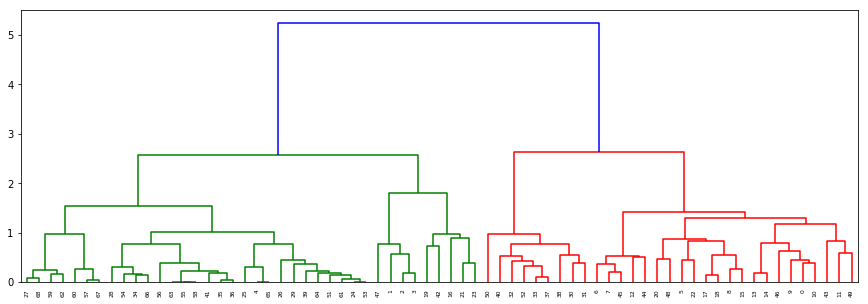

In [206]:
# hierachical clustering
svec = RohG[np.triu_indices(len(RohG),1)]
dist = 1 - svec
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
plt.figure(figsize=(15, 5))
dn = scl.hierarchy.dendrogram(link)

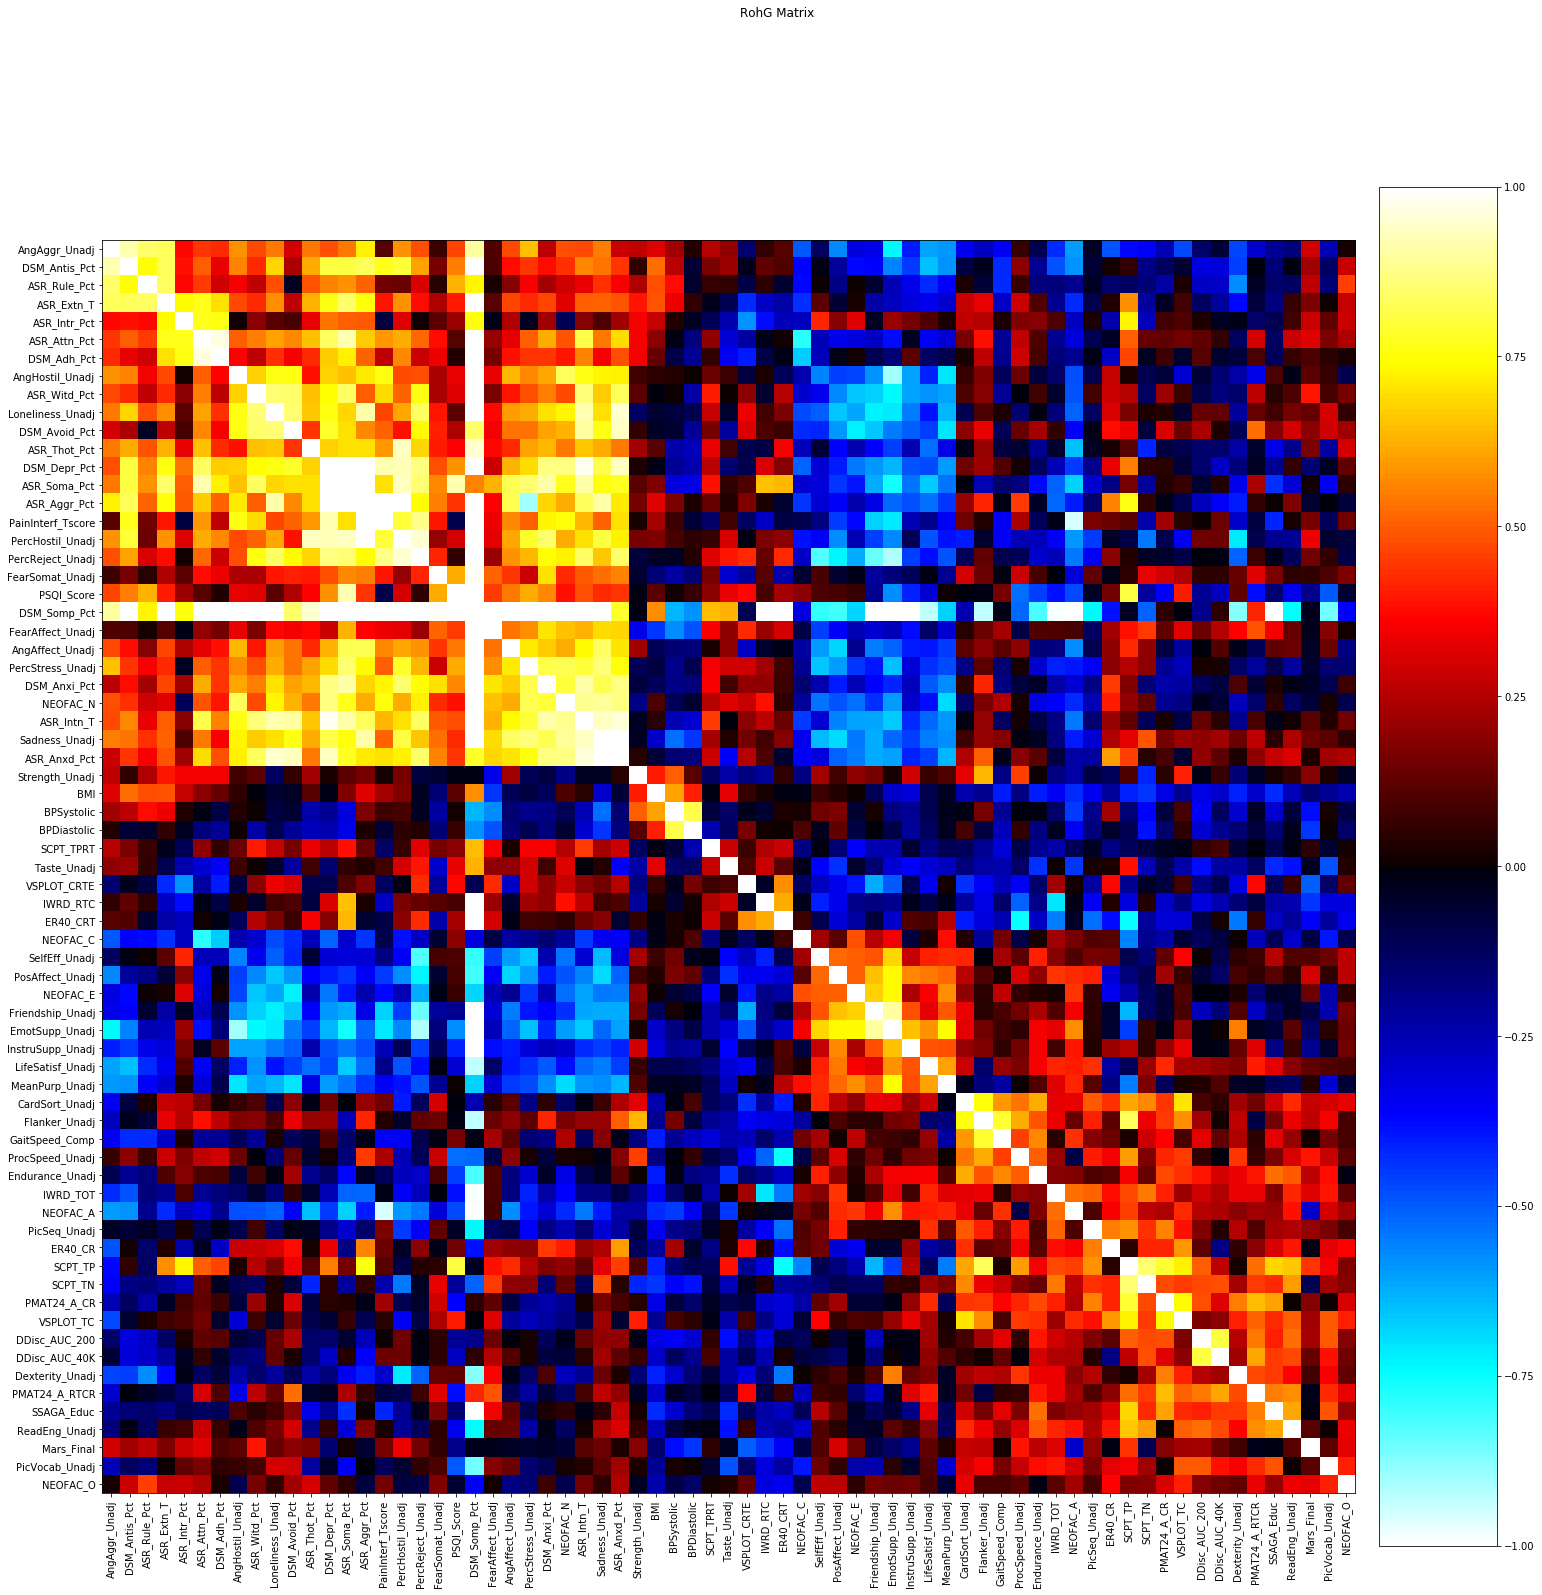

In [207]:
# Plot the RhoG matrix again, but now ordered by hierarchy
use_columns = pheno_clean_df.columns.drop('ID')
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(RohG[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RohG Matrix')

In [208]:
# Order clustered correlation matrix
RohG_clust = RohG[order, :][:, order]
RohG_p0_fd_clust = RohG_p0_fd[order, :][:, order]
RohG_p1_fd_clust = RohG_p1_fd[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

In [209]:
# Generate boxes
mat, cmat, lmat, ind = make_boxes(RohG_clust, cuts, 2)
mat_fd0, cmat_fd0, lmat_fd0, ind_fd0 = make_boxes(RohG_p0_fd_clust, cuts, 2)
mat_fd1, cmat_fd1, lmat_fd1, ind_fd1 = make_boxes(RohG_p1_fd_clust, cuts, 2)

#### RhoG 

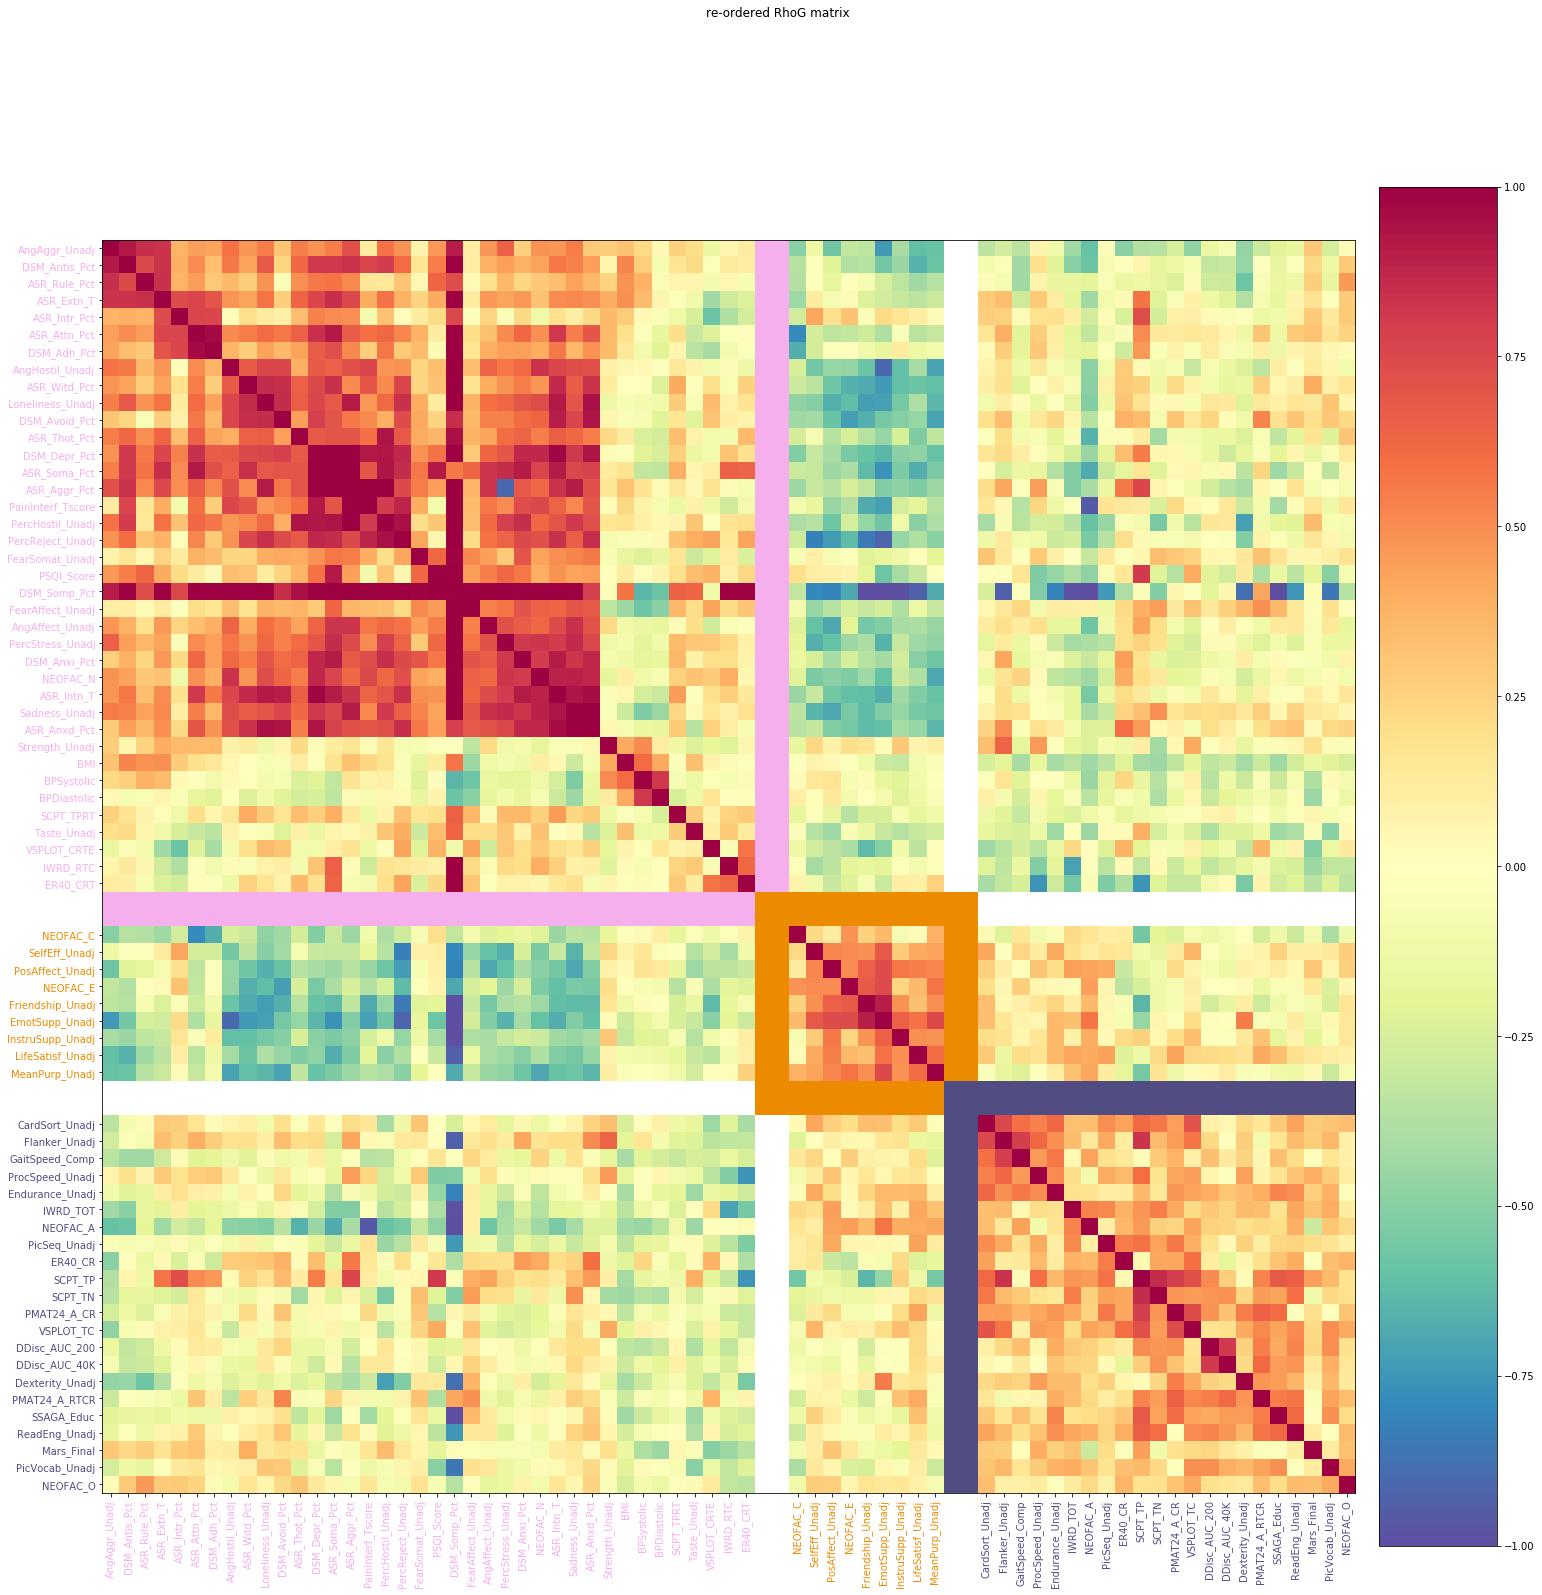

In [210]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat, cmap=plt.cm.Spectral_r,interpolation='none', vmin=-1, vmax=1)
tmp = ax.imshow(lmat, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(ind)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered RhoG matrix')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

#### RhoG pval 0

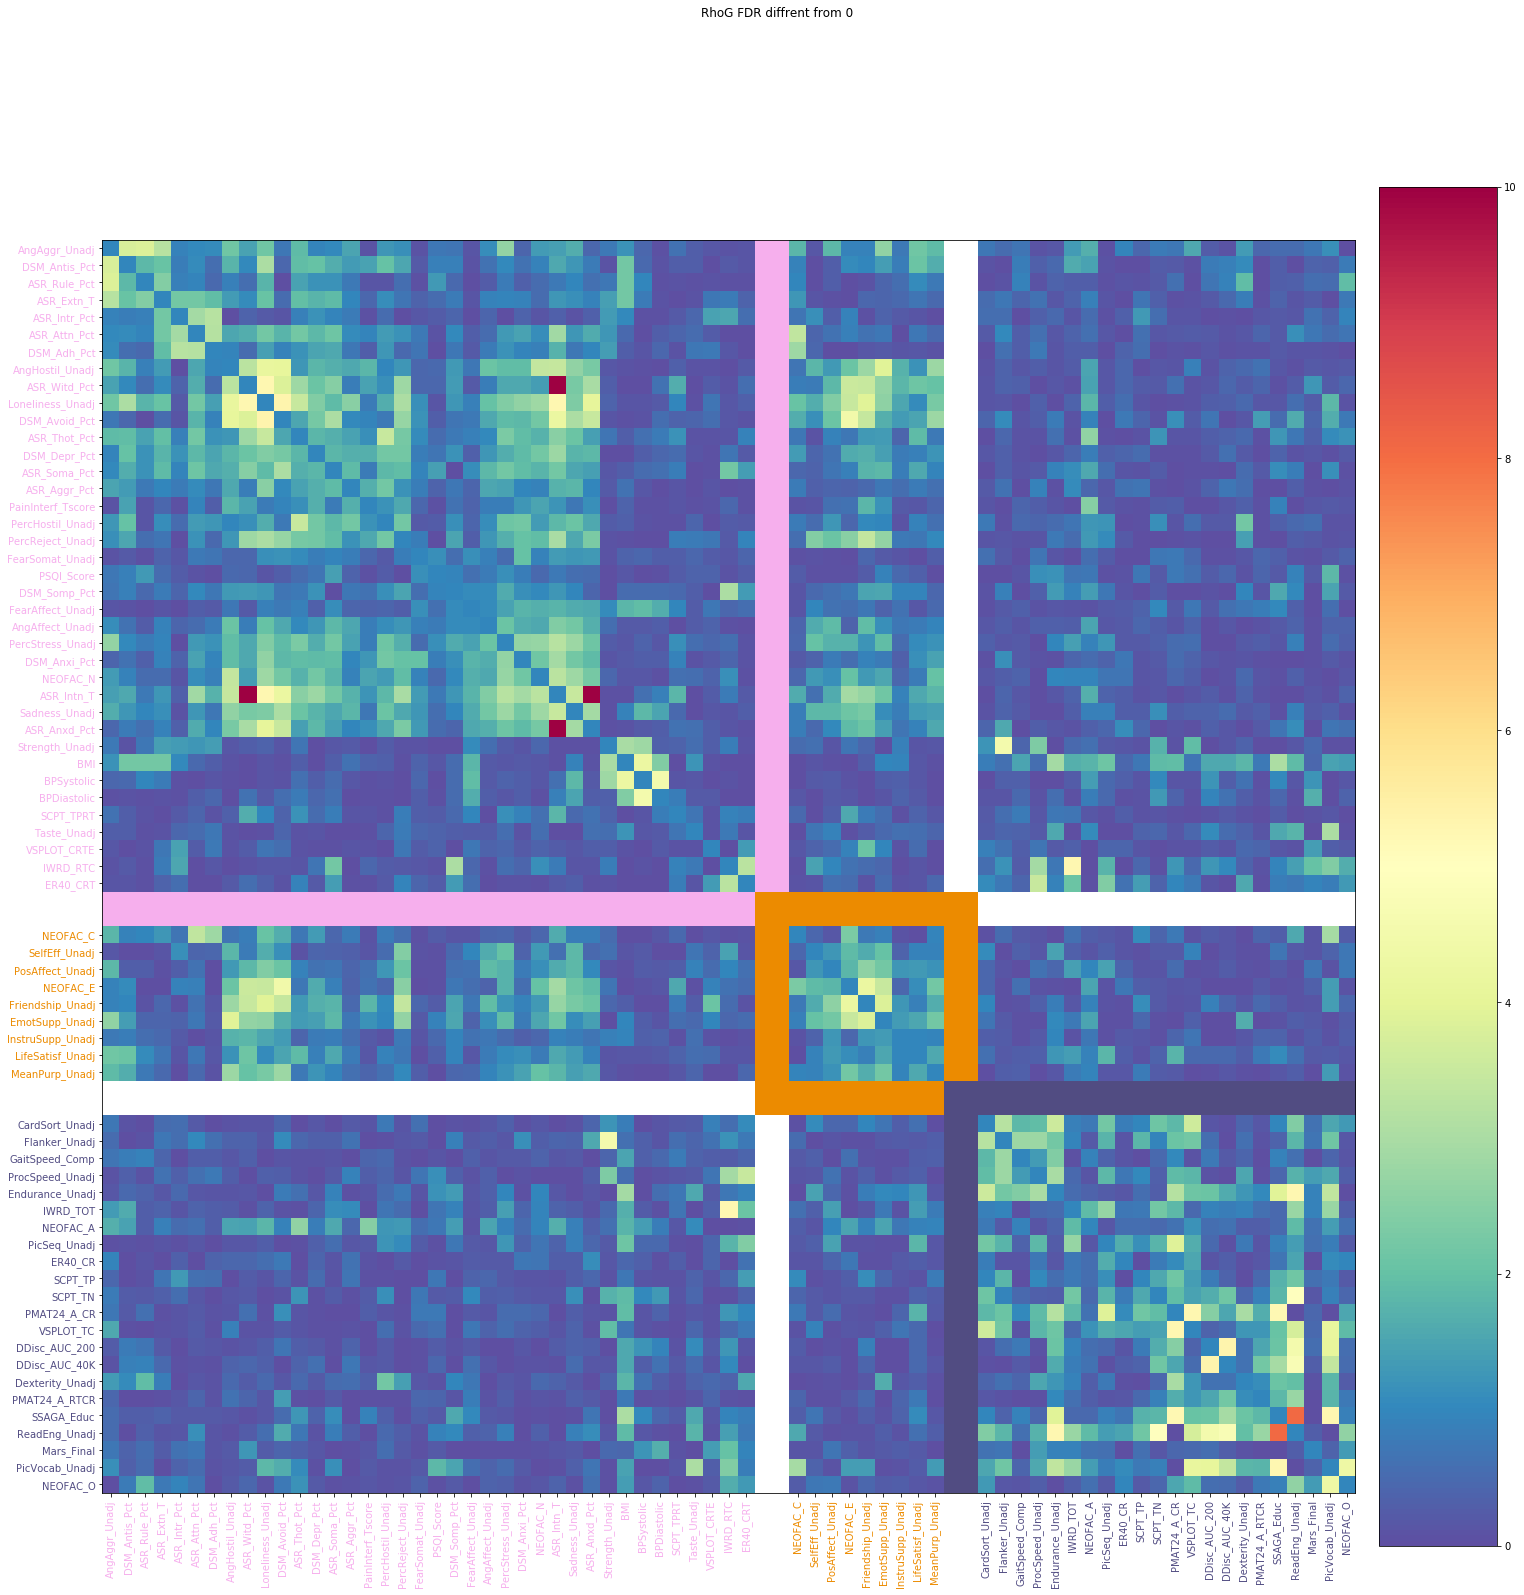

In [213]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat_fd0, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=10)
tmp = ax.imshow(lmat_fd0, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat_fd0, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat_fd0, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(ind_fd0)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind_fd0)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoG FDR diffrent from 0')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

#### RhoG pval 1

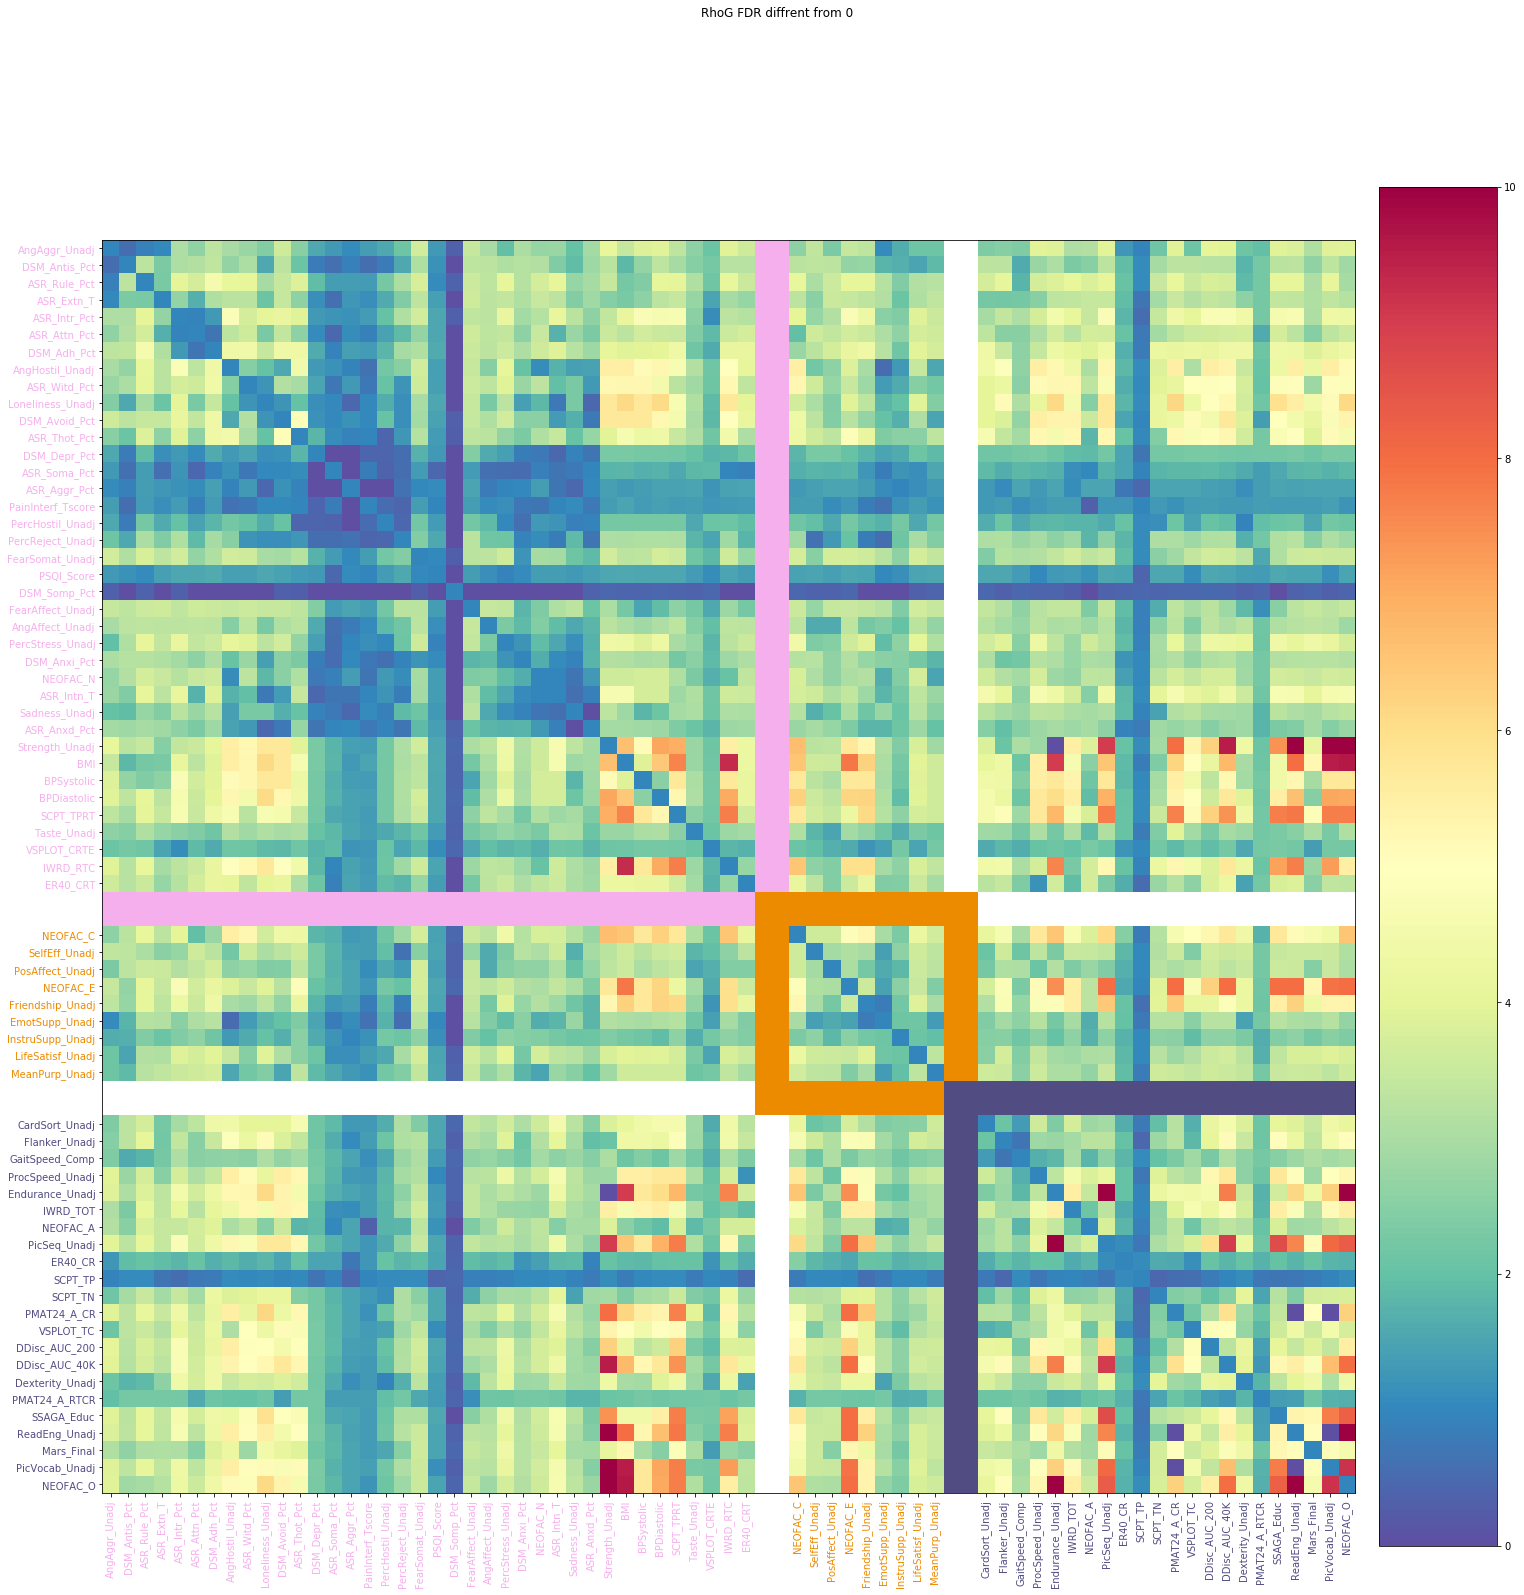

In [214]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(mat_fd1, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=10)
tmp = ax.imshow(lmat_fd1, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmat_fd1, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmat_fd1, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(ind_fd1)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(ind_fd1)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoG FDR diffrent from 0')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

### Cluster RhoE matrice

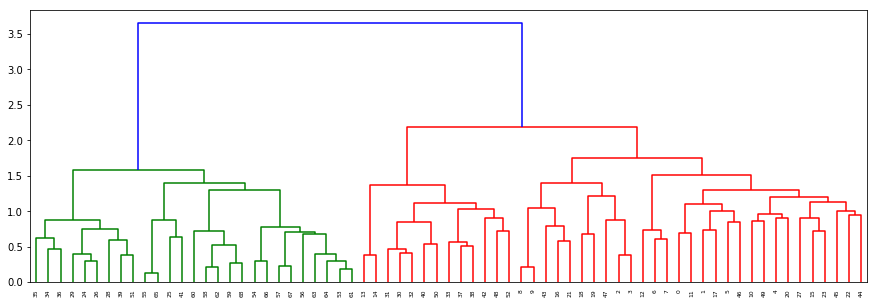

In [215]:
# hierachical clustering
svec = RohE[np.triu_indices(len(RohE),1)]
dist = 1 - svec
n_sbt = 3
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
plt.figure(figsize=(15, 5))
dn = scl.hierarchy.dendrogram(link)

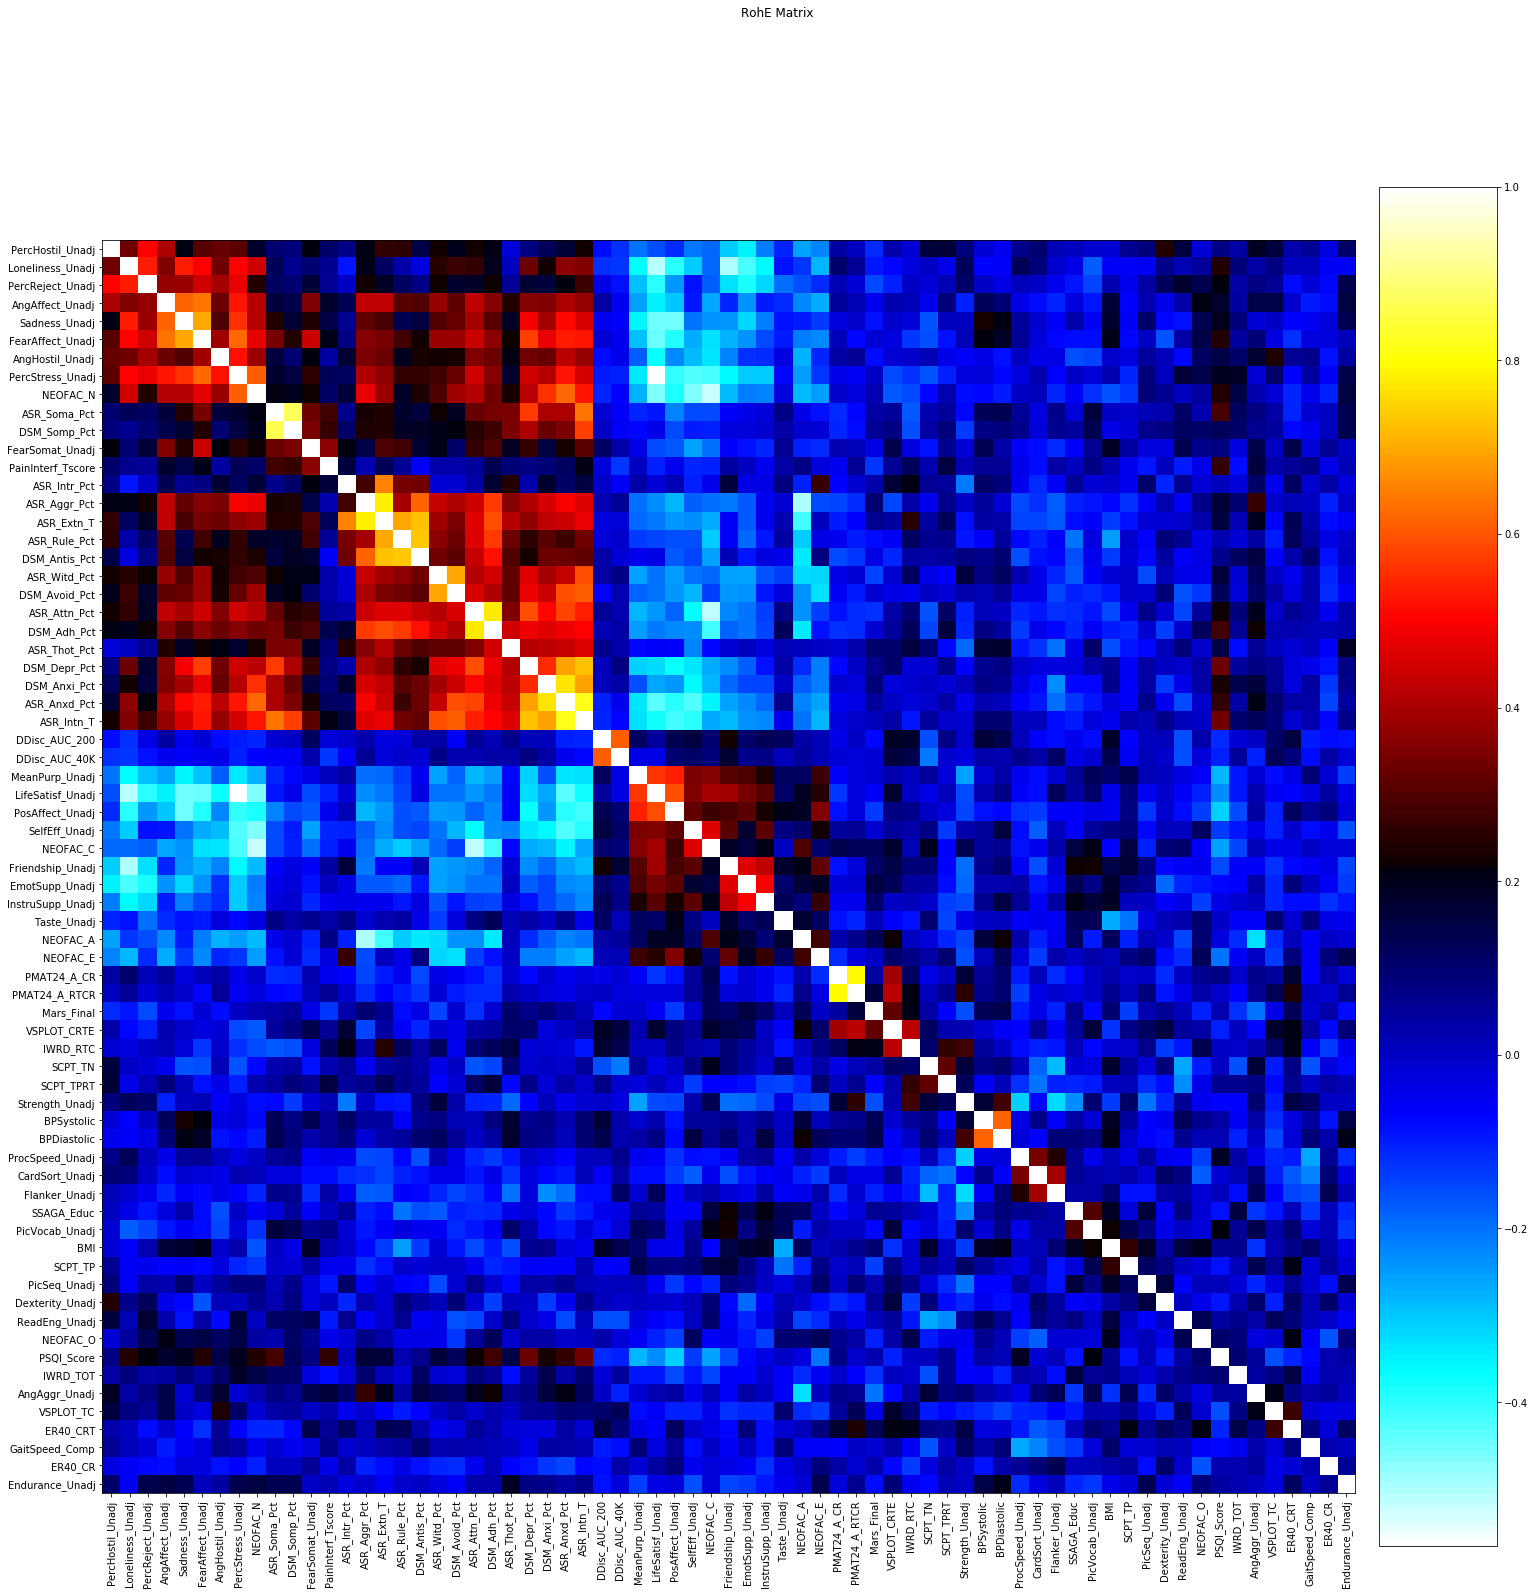

In [217]:
# Plot the RhoE matrix again, but now ordered by hierarchy
use_columns = pheno_clean_df.columns.drop('ID')
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(RohE[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RohE Matrix')

In [219]:
# Order clustered correlation matrix
RohE_clust = RohE[order, :][:, order]
RohE_p_fd_clust = RohE_p_fd[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

In [220]:
# Generate boxes
matE, cmatE, lmatE, indE = make_boxes(RohE_clust, cuts, 2)
matE_fd, cmatE_fd, lmatE_fd, indE_fd = make_boxes(RohE_p_fd_clust, cuts, 2)

#### RhoE 

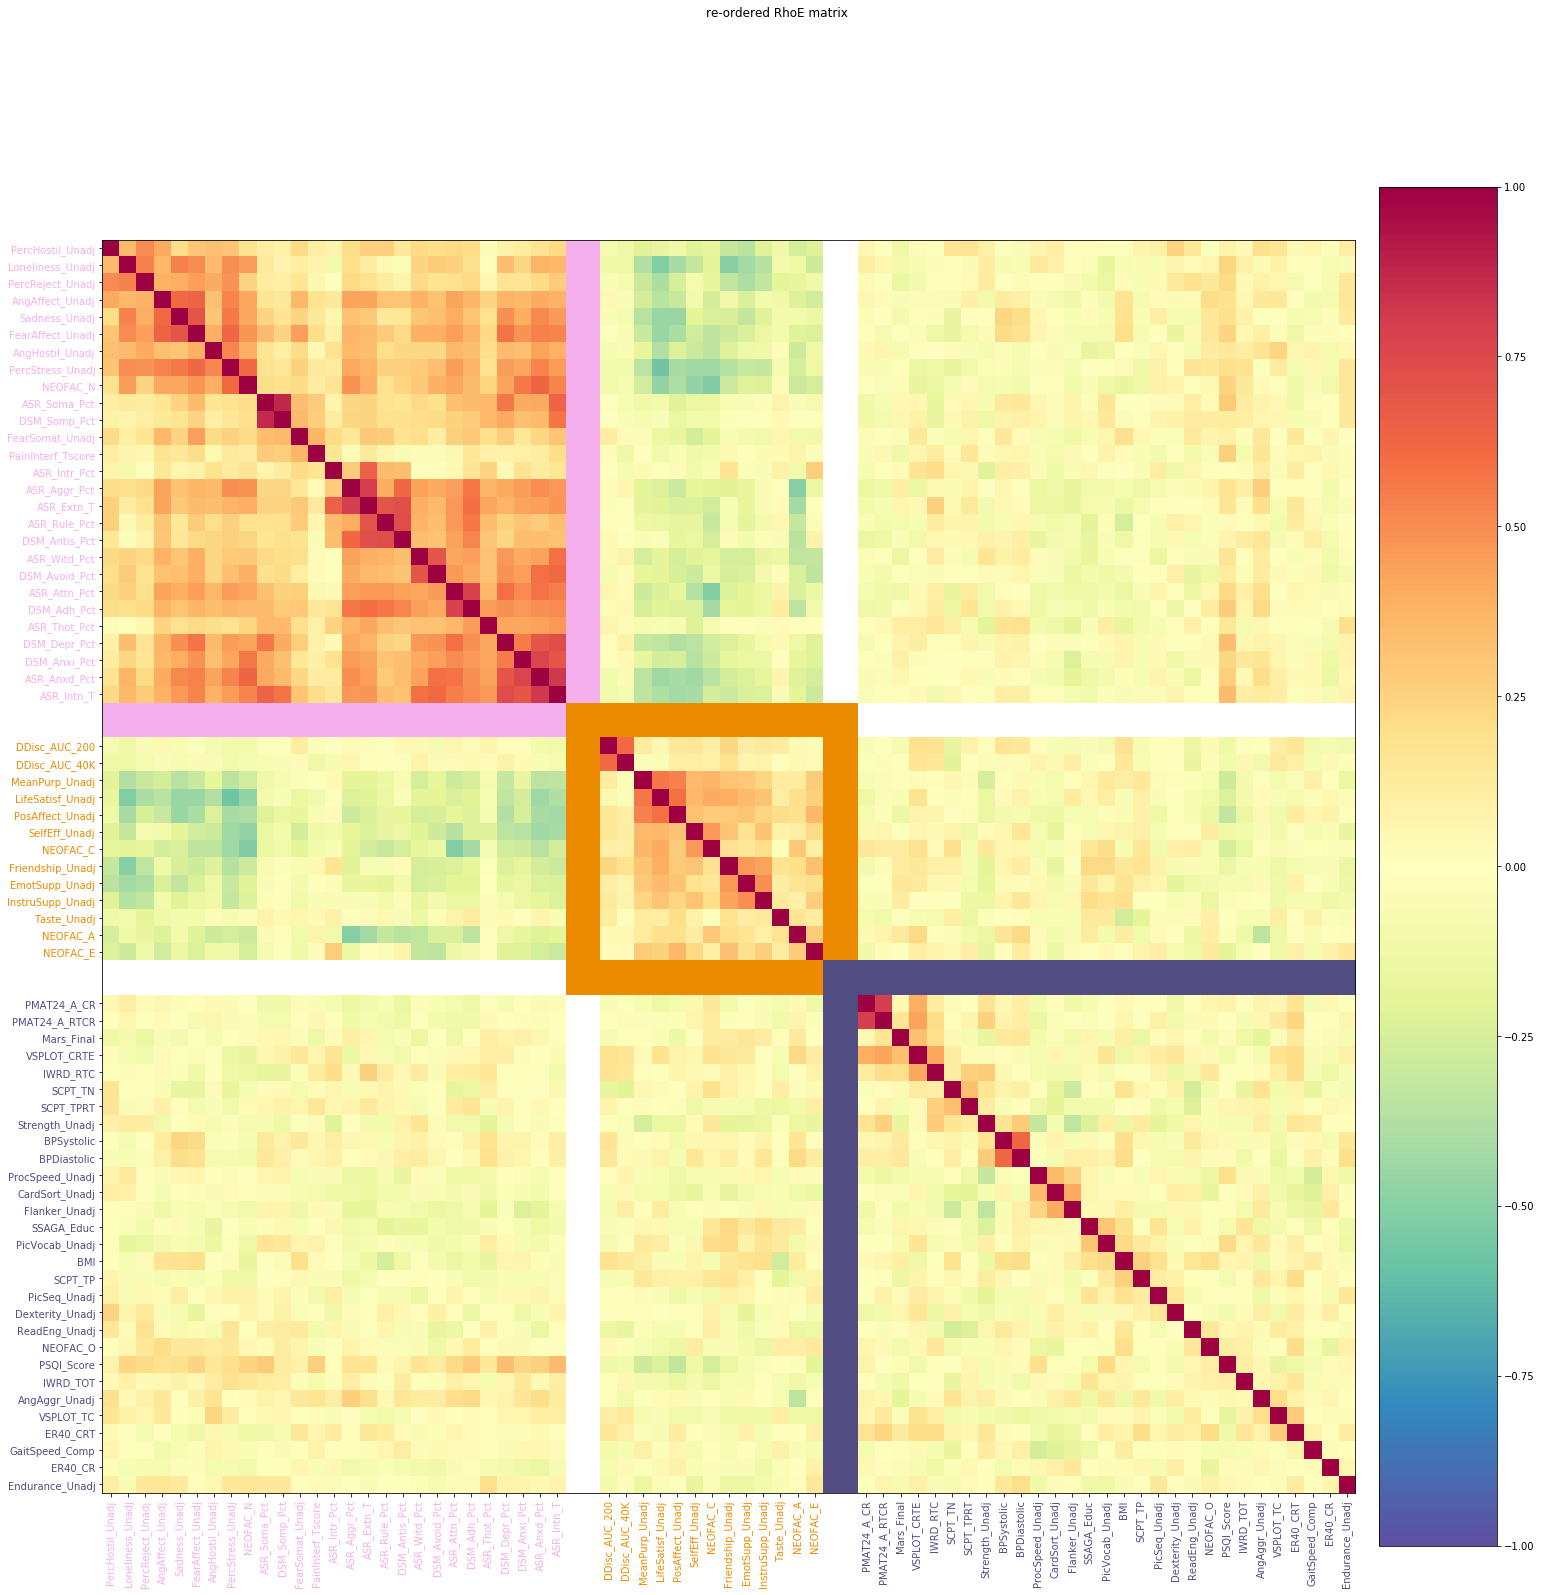

In [222]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matE, cmap=plt.cm.Spectral_r,interpolation='none', vmin=-1, vmax=1)
tmp = ax.imshow(lmatE, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmatE, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmatE, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(indE)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indE)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered RhoE matrix')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

#### RhoE pval

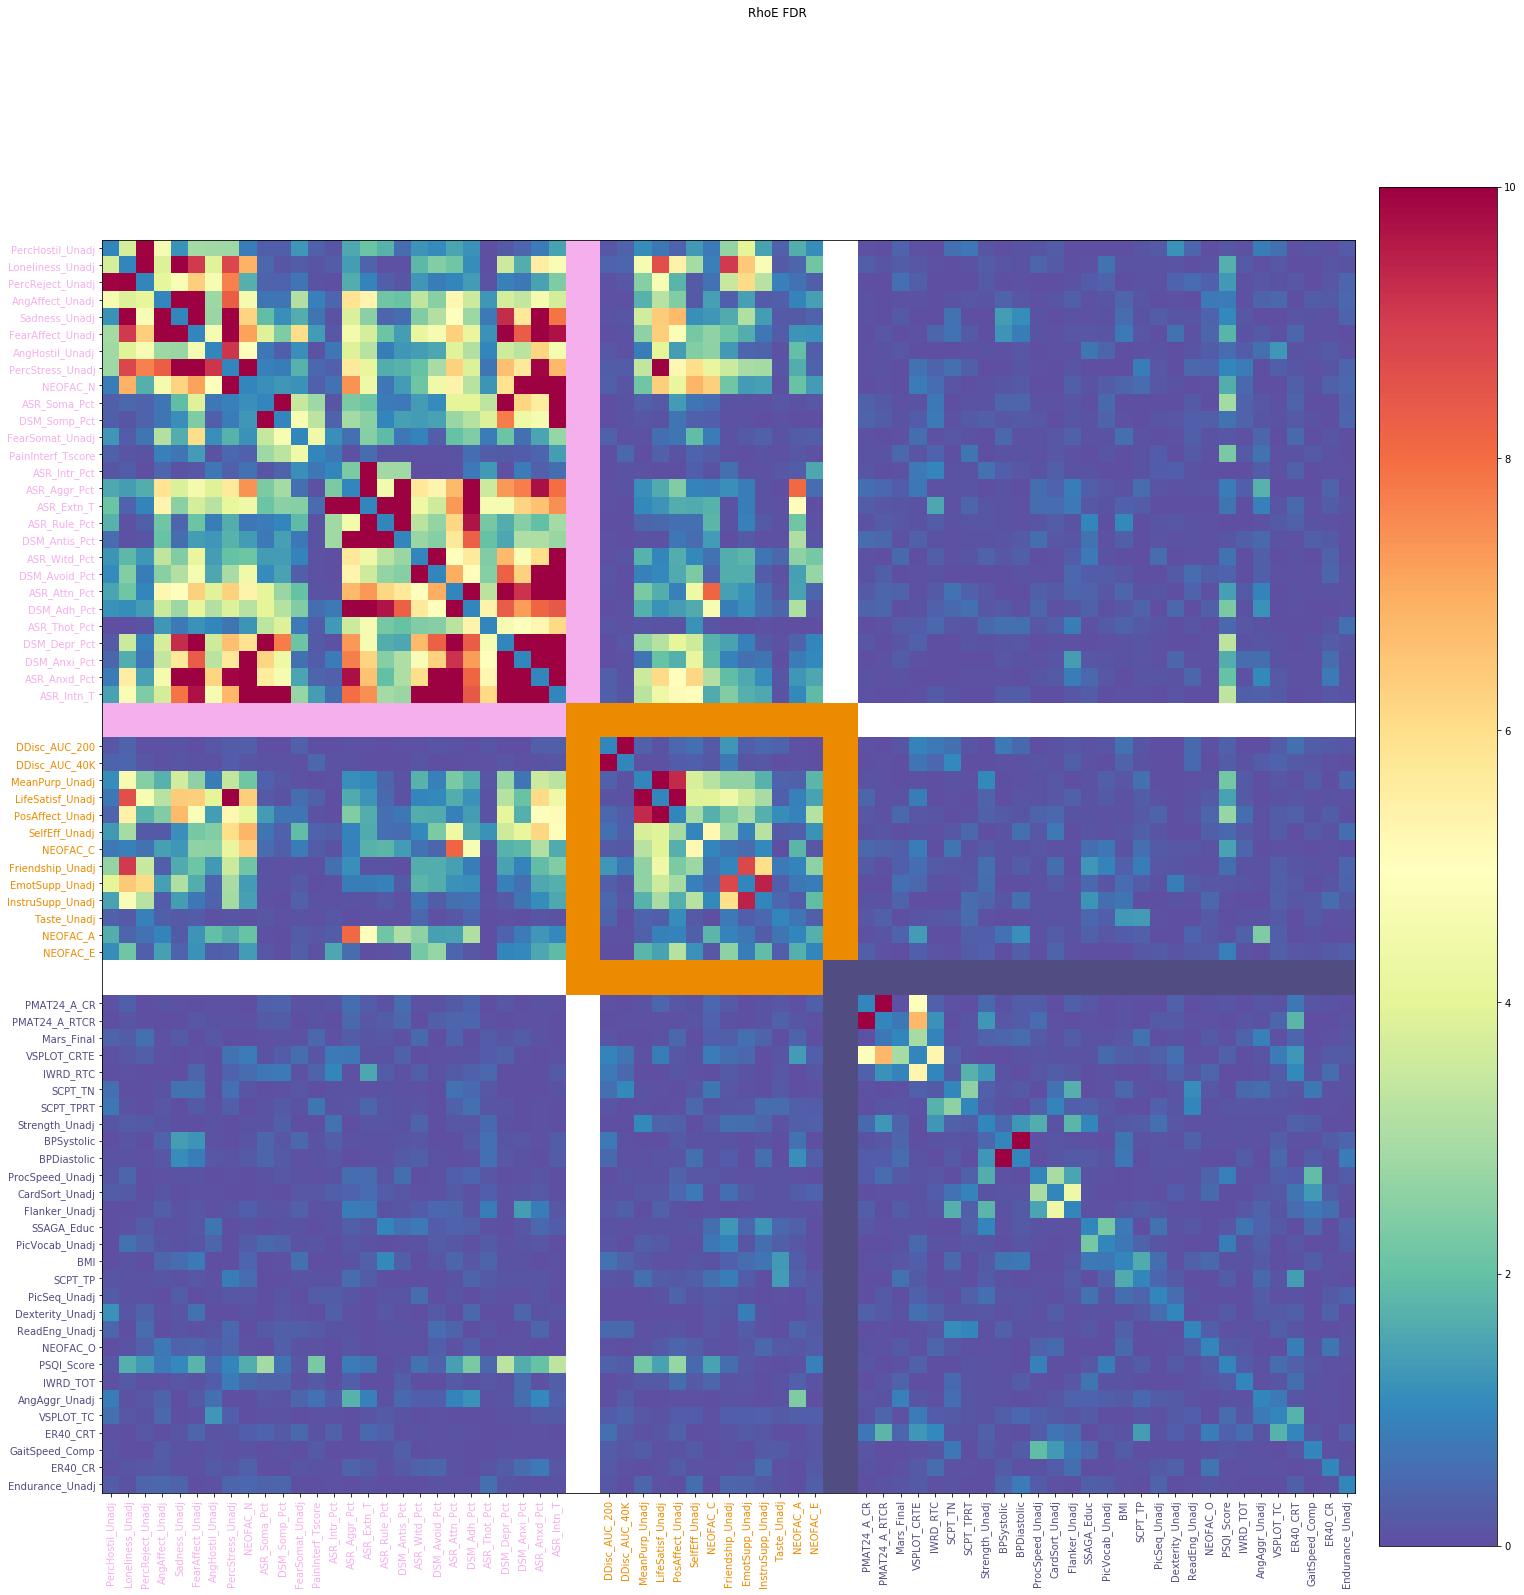

In [224]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matE_fd, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=10)
tmp = ax.imshow(lmatE_fd, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmatE_fd, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmatE_fd, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(indE_fd)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indE_fd)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoE FDR')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

### Cluster RhoP matrice

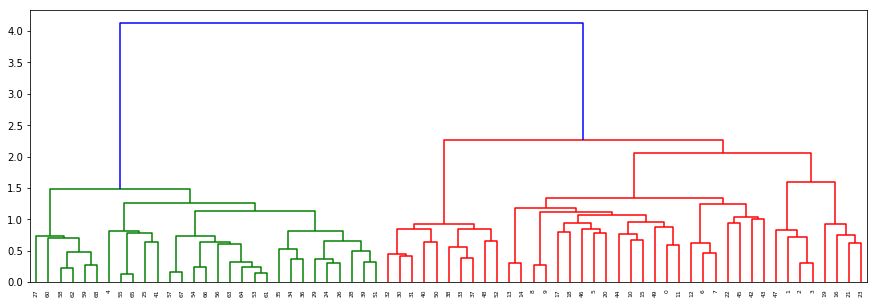

In [225]:
# hierachical clustering
svec = RohP[np.triu_indices(len(RohP),1)]
dist = 1 - svec
n_sbt = 3
link = scl.hierarchy.linkage(dist, method='ward')
part = scl.hierarchy.fcluster(link, n_sbt, criterion='maxclust')
order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
plt.figure(figsize=(15, 5))
dn = scl.hierarchy.dendrogram(link)

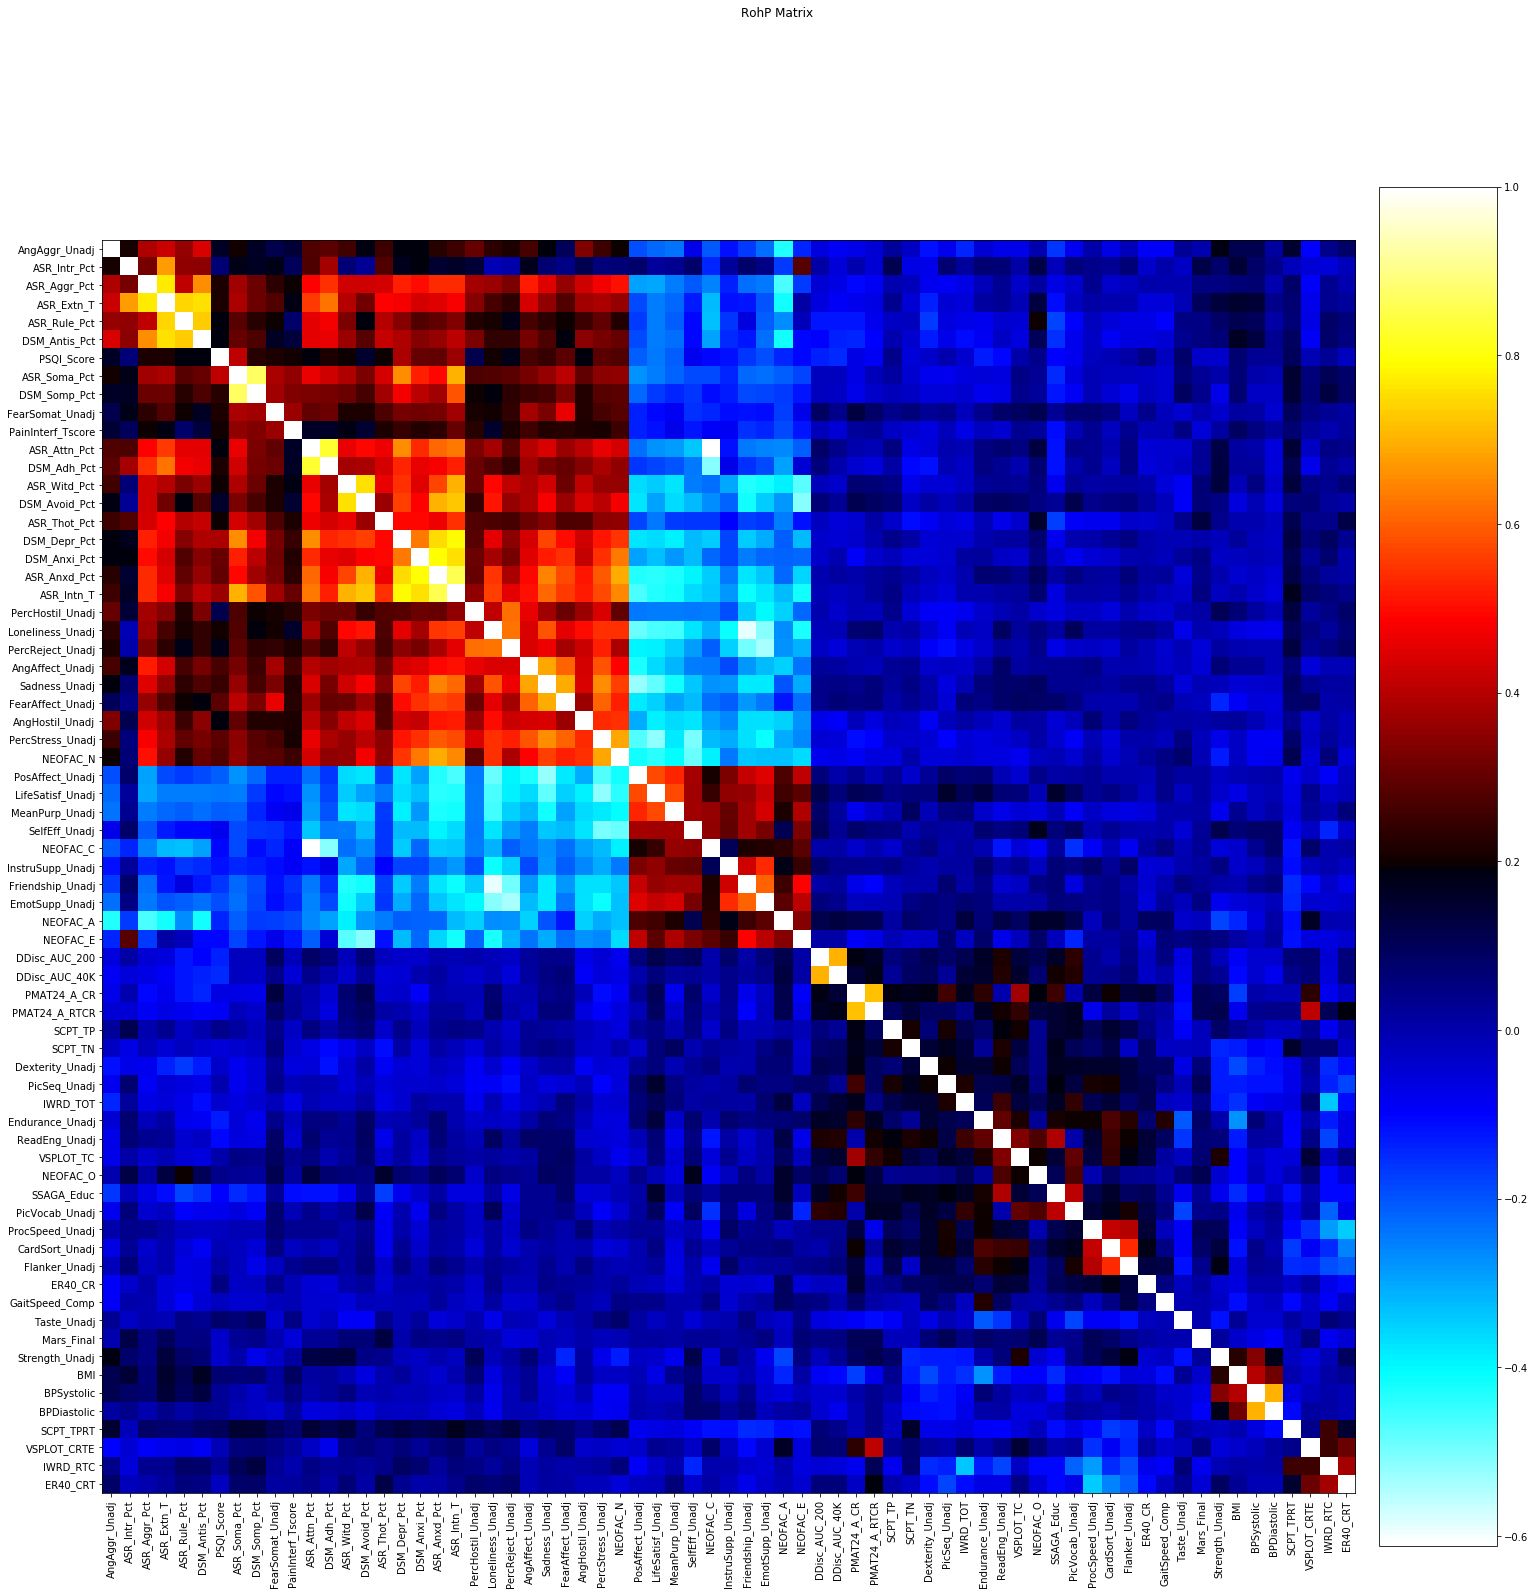

In [226]:
# Plot the RhoP matrix again, but now ordered by hierarchy
use_columns = pheno_clean_df.columns.drop('ID')
label_ord = [use_columns[ord] for ord in order]
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(RohP[order, :][:, order],cmap =nlp.cm.cold_hot,interpolation='none')
tmp = ax.set_yticks(range(len(use_columns)))
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(range(len(use_columns)))
tmp = ax.set_xticklabels(label_ord, rotation=90)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RohP Matrix')

In [227]:
# Order clustered correlation matrix
RohP_clust = RohP[order, :][:, order]
RohP_p_fd_clust = RohP_p_fd[order, :][:, order]
pco = part[order]

# Set start/stop boxes positions
cuts = [(np.min(np.argwhere(pco==i)), np.max(np.argwhere(pco==i)))for i in np.unique(pco)]

In [228]:
# Generate boxes
matP, cmatP, lmatP, indP = make_boxes(RohP_clust, cuts, 2)
matP_fd, cmatP_fd, lmatP_fd, indP_fd = make_boxes(RohP_p_fd_clust, cuts, 2)

#### RhoP 

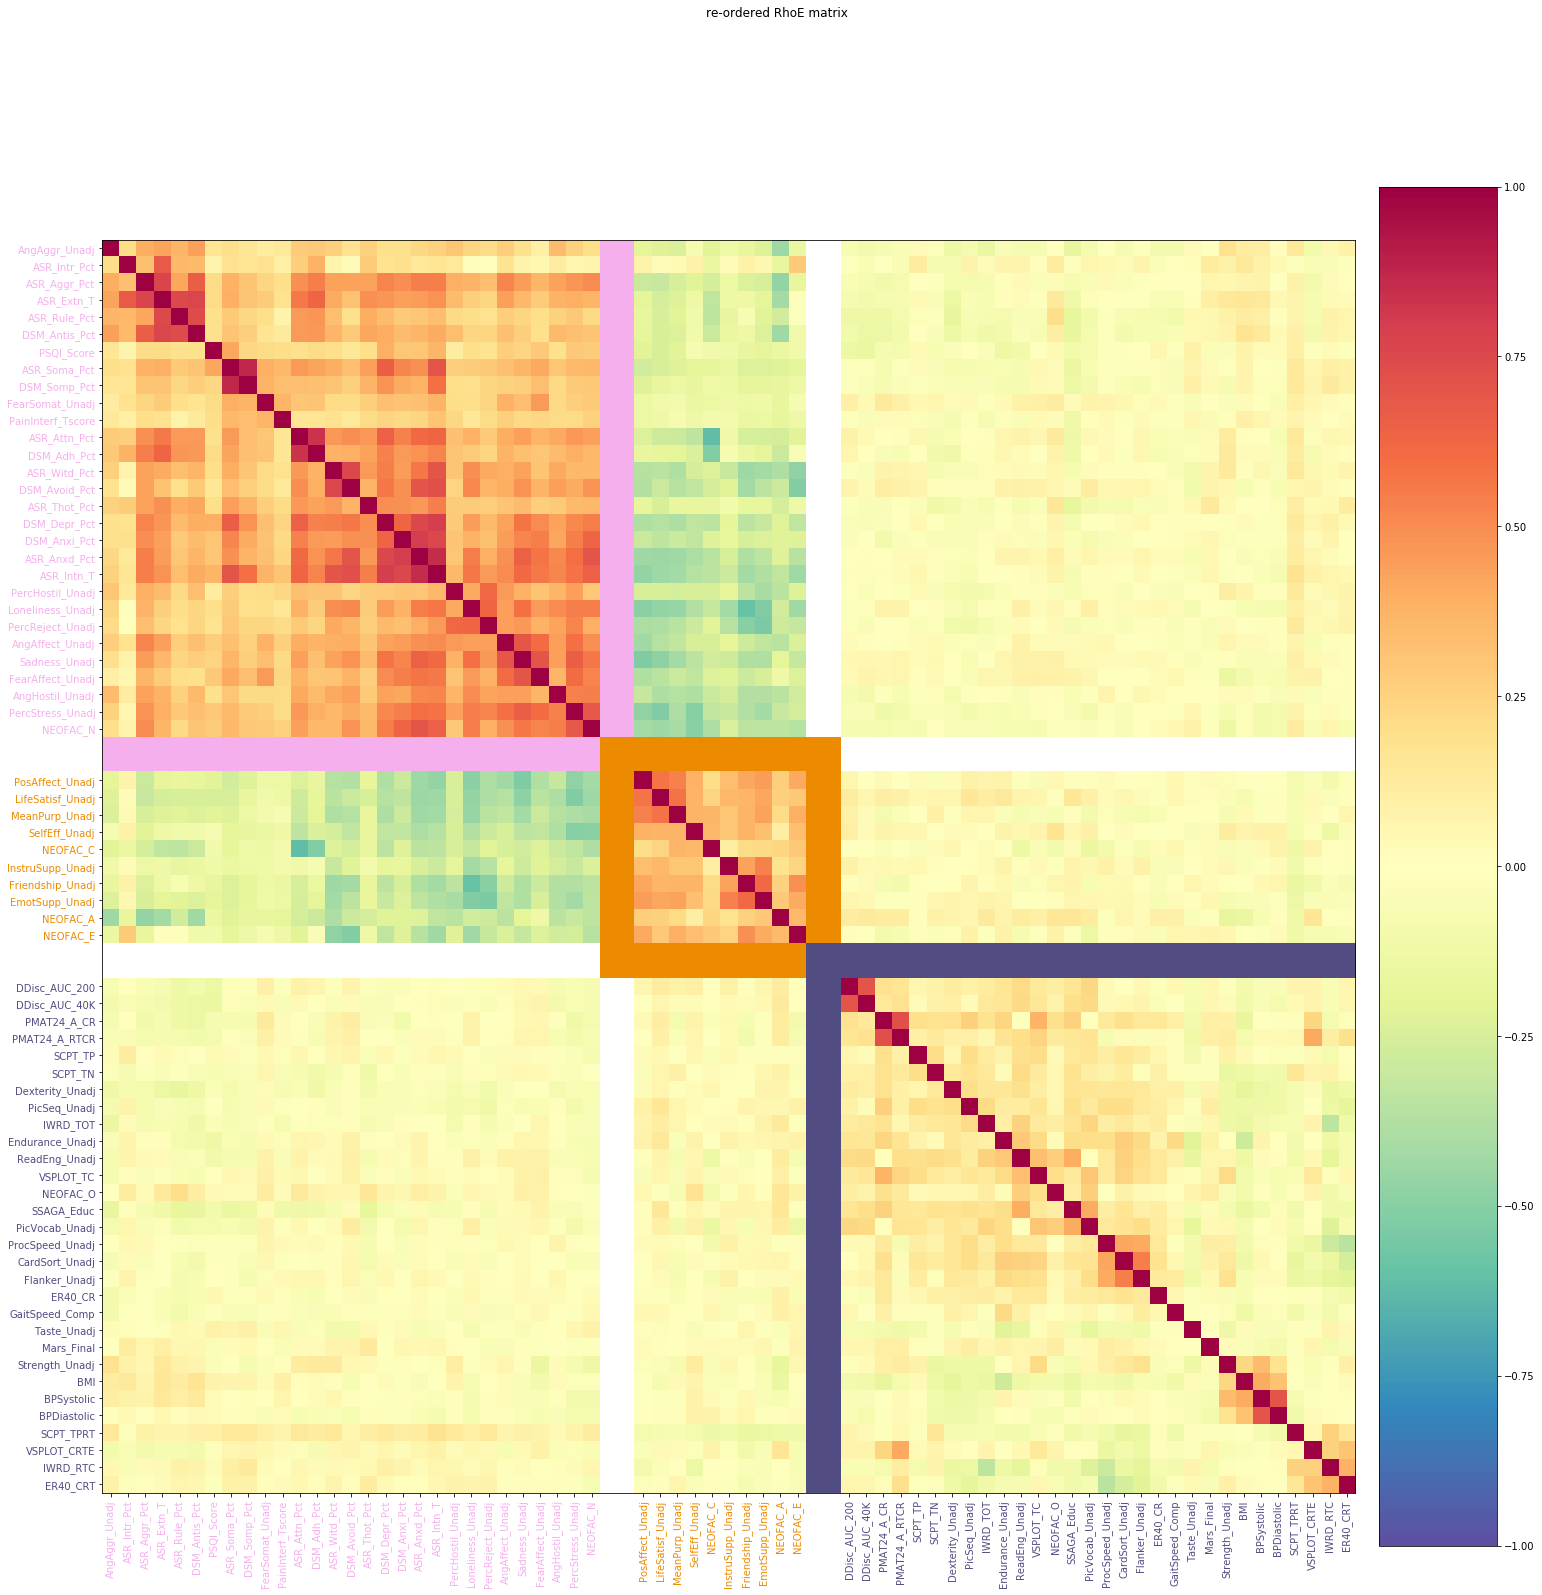

In [229]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matP, cmap=plt.cm.Spectral_r,interpolation='none', vmin=-1, vmax=1)
tmp = ax.imshow(lmatP, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmatP, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmatP, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(indP)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indP)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('re-ordered RhoE matrix')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))

#### RhoP pval

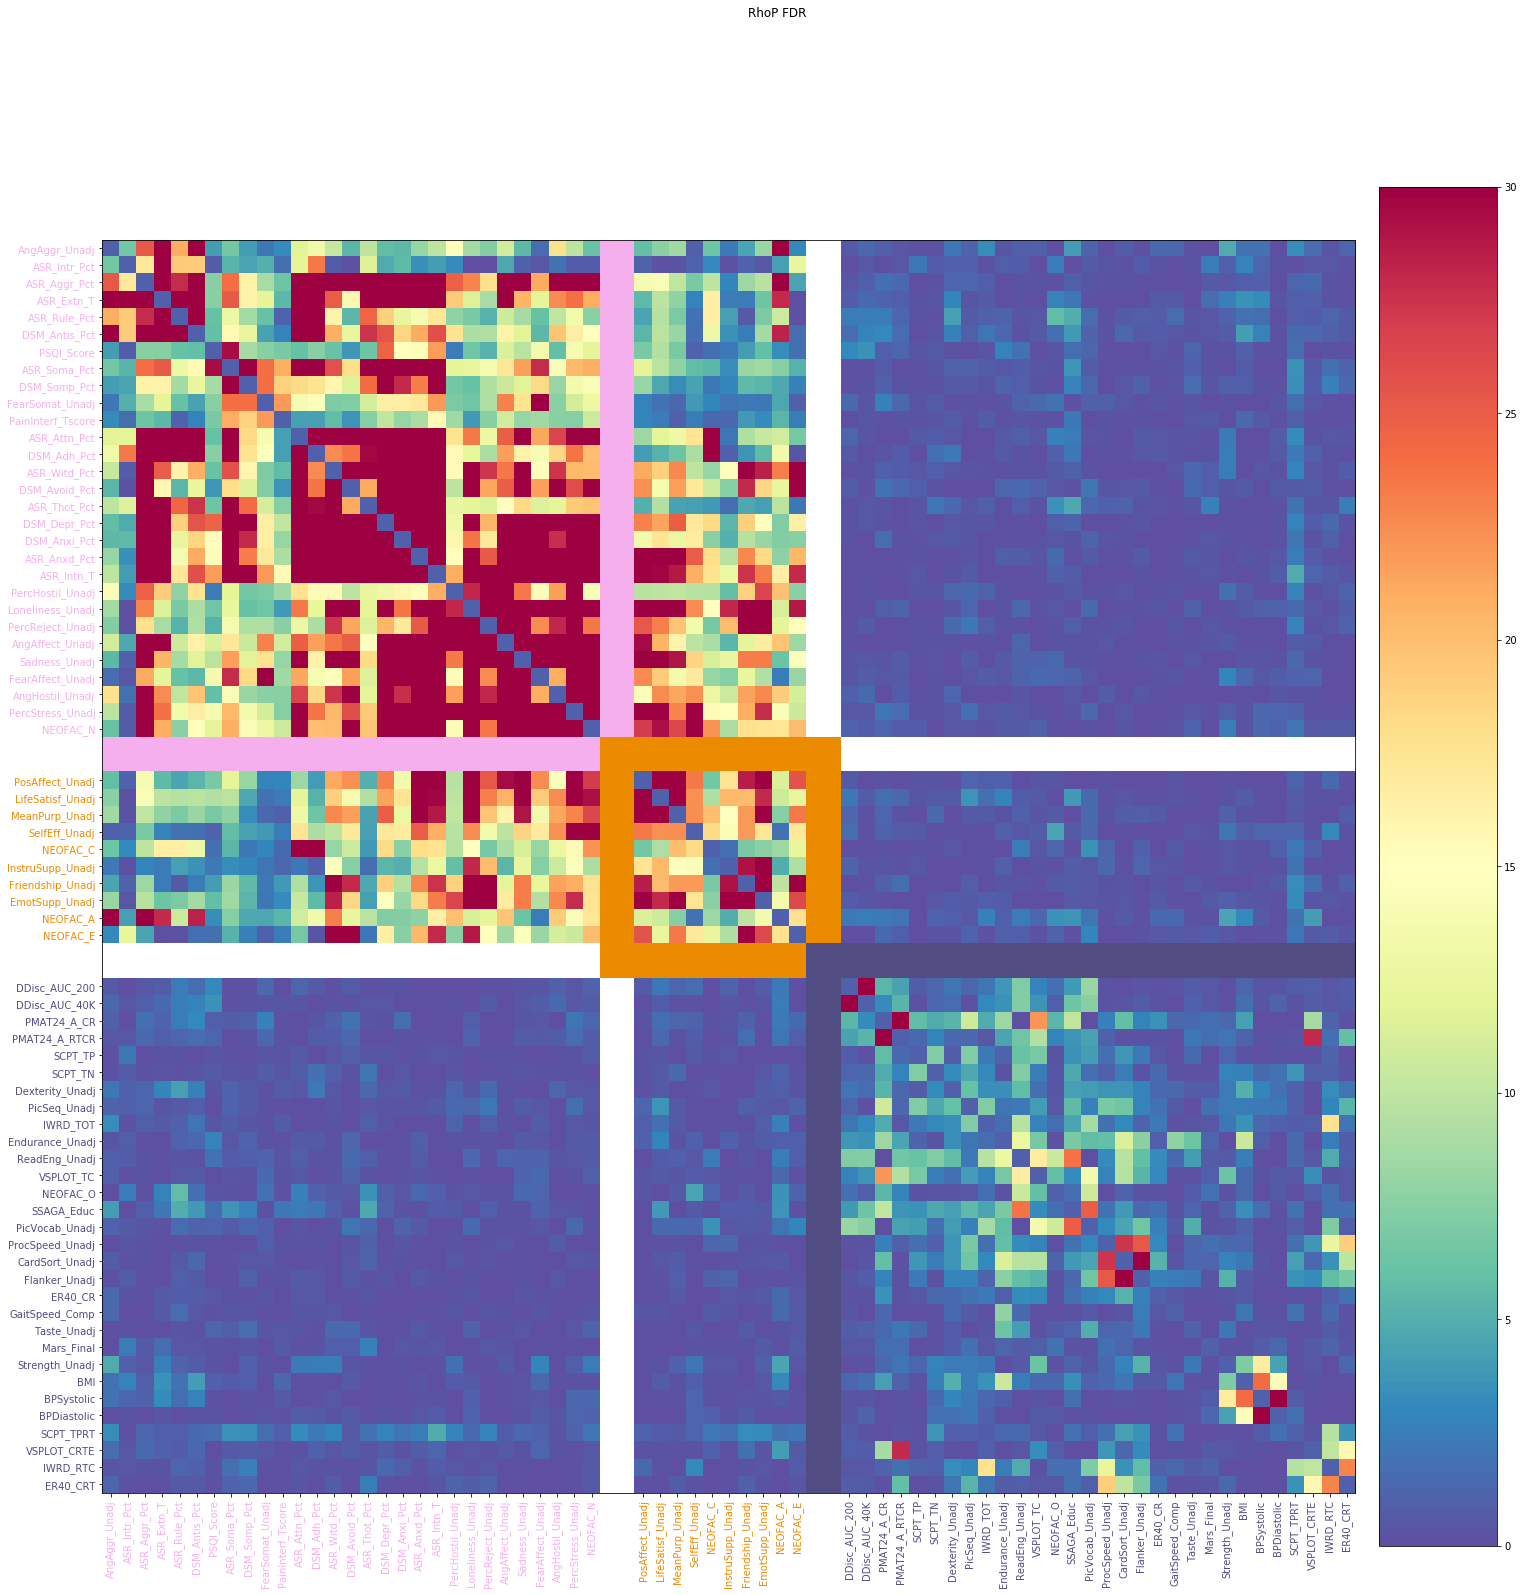

In [234]:
# Set figure
f = plt.figure(figsize=(25,25))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(matP_fd, cmap=plt.cm.Spectral_r,interpolation='none',vmin=0,vmax=30)
tmp = ax.imshow(lmatP_fd, cmap=plt.cm.Greys_r,interpolation='none')
tmp = ax.imshow(lmatP_fd, cmap=plt.cm.Greys, alpha=1,interpolation='none')
tmp = ax.imshow(cmatP_fd, cmap=struc[str(n_sbt)]['lin'],interpolation='none')
tmp = ax.set_yticks(indP_fd)
tmp = ax.set_yticklabels(label_ord)
tmp = ax.set_xticks(indP_fd)
tmp = ax.set_xticklabels(label_ord, rotation=90)
# set labels colors
#colors = [s3_colors[i-1] for i in pco]
colors = [struc[str(n_sbt)]['s_colors'][i-1] for i in pco]
for xtick,ytick,color in zip(ax.get_xticklabels(),ax.get_yticklabels(),colors):
    xtick.set_color(color)
    ytick.set_color(color)
tmp = f.colorbar(p, cax=axcl)
tmp = f.suptitle('RhoP FDR')
#f.savefig(os.path.join(path_root,'Figures/associations/pheno_clustered.svg'))